<a href="https://colab.research.google.com/github/itimes-digital/olist_analise/blob/main/olist_analise_de_negocio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [192]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as md
import seaborn as sns
from scipy import stats

In [2]:
# Este item é necessário para instalação do Facebook Prophet que será usado para séries temporais 
!pip install fbprophet

In [3]:
from fbprophet import Prophet

In [4]:
ds_clientes = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_customers_dataset.csv?raw=true');
ds_pedido_itens = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_order_items_dataset.csv?raw=true');
ds_pedido_pagamentos = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_order_payments_dataset.csv?raw=true');
ds_reviews = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_order_reviews_dataset.csv?raw=true');
ds_pedidos = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_orders_dataset.csv?raw=true');
ds_produtos = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_products_dataset.csv?raw=true');
ds_vendedores = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/olist_sellers_dataset.csv?raw=true');
ds_categorias = pd.read_csv('https://github.com/itimes-digital/olist_analise/blob/main/dataset/product_category_name_translation.csv?raw=true');

# Análise de clientes

In [5]:
ds_clientes.head()

customer_id  ... customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...             SP
1  18955e83d337fd6b2def6b18a428ac77  ...             SP
2  4e7b3e00288586ebd08712fdd0374a03  ...             SP
3  b2b6027bc5c5109e529d4dc6358b12c3  ...             SP
4  4f2d8ab171c80ec8364f7c12e35b23ad  ...             SP

[5 rows x 5 columns]

In [6]:
ds_clientes.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [7]:
ds_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [8]:
ds_clientes.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

## Percentual de Clientes e Recorrência de Compras

In [9]:
total_clientes = ds_clientes['customer_id'].nunique()
total_clientes_unico = ds_clientes['customer_unique_id'].nunique()

percentual = round((total_clientes_unico / total_clientes) * 100, 2)

diferenca = total_clientes - total_clientes_unico

print('Dos {0} registros de compradores, temos {1}% de compradores com apenas um registro de compra.'.format(total_clientes, percentual))
print('\nEnquanto isso, temos apenas {0} clientes que voltaram a comprar na loja.'.format(diferenca))
print('\nPortanto, {0}% de recorrência.'.format(round((100 - percentual), 2)))
print('\nEm um primeiro momento, podemos concluir que o LTV - Lifetime Value - desta amostra está baixo.')

Dos 99441 registros de compradores, temos 96.64% de compradores com apenas um registro de compra.

Enquanto isso, temos apenas 3345 clientes que voltaram a comprar na loja.

Portanto, 3.36% de recorrência.

Em um primeiro momento, podemos concluir que o LTV - Lifetime Value - desta amostra está baixo.


In [10]:
ds_clientes.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [11]:
ds_novo_clientes_cluster = ds_clientes[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']]
ds_novo_clientes_cluster.head()

customer_id  ... customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...             SP
1  18955e83d337fd6b2def6b18a428ac77  ...             SP
2  4e7b3e00288586ebd08712fdd0374a03  ...             SP
3  b2b6027bc5c5109e529d4dc6358b12c3  ...             SP
4  4f2d8ab171c80ec8364f7c12e35b23ad  ...             SP

[5 rows x 4 columns]

## Distribuição de Clientes pelo Brasil

A maior concentração de clientes encontra-se na região sudeste e sul, ultrapassando a marca de +70 mil clientes.

Porém, o consumo está mais atrelado as capitais, sendo a cidade de São Paulo com 15.540 compradores em um universo de 99.441 clientes.

In [12]:
ds_novo_clientes_cluster['customer_state'].describe()

count     99441
unique       27
top          SP
freq      41746
Name: customer_state, dtype: object

In [13]:
ds_novo_clientes_cluster['customer_state'].value_counts()

SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_state, dtype: int64

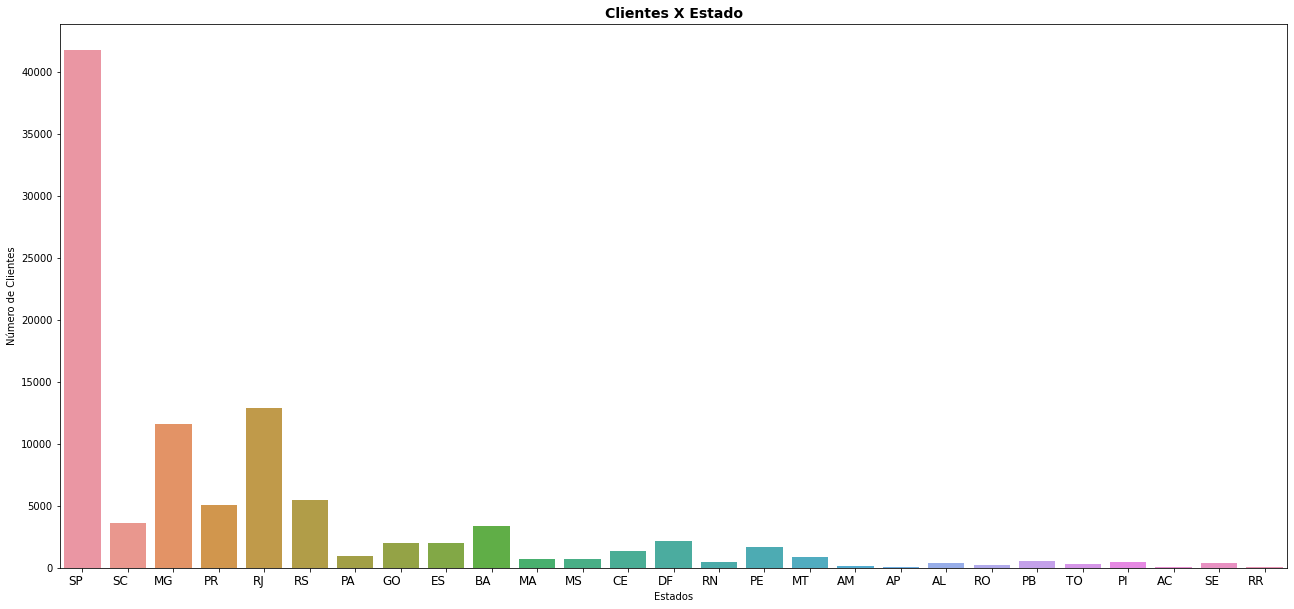

In [14]:
ds_novo_clientes_cluster = ds_novo_clientes_cluster.drop_duplicates()
estados = ds_novo_clientes_cluster['customer_state'].unique()
plt.figure(figsize=(22,10))

ax = sns.countplot(x = 'customer_state',  
                   data = ds_novo_clientes_cluster, 
                   order = estados)

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation = 0, 
                   ha = 'right', 
                   fontsize = 12)

plt.title('Clientes X Estado', fontsize = 14, fontweight = 'bold')
plt.xlabel('Estados') 
plt.ylabel('Número de Clientes')
plt.show()

In [15]:
ds_novo_clientes_cluster['customer_city'].describe()

count         99441
unique         4119
top       sao paulo
freq          15540
Name: customer_city, dtype: object

In [16]:
ds_novo_clientes_cluster['customer_city'].value_counts()

sao paulo            15540
rio de janeiro        6882
belo horizonte        2773
brasilia              2131
curitiba              1521
                     ...  
bequimao                 1
andarai                  1
vargem grande            1
curvelandia              1
eugenio de castro        1
Name: customer_city, Length: 4119, dtype: int64

# Análise dos Itens de Pedidos

In [17]:
ds_pedido_itens.head()

order_id  order_item_id  ...   price freight_value
0  00010242fe8c5a6d1ba2dd792cb16214              1  ...   58.90         13.29
1  00018f77f2f0320c557190d7a144bdd3              1  ...  239.90         19.93
2  000229ec398224ef6ca0657da4fc703e              1  ...  199.00         17.87
3  00024acbcdf0a6daa1e931b038114c75              1  ...   12.99         12.79
4  00042b26cf59d7ce69dfabb4e55b4fd9              1  ...  199.90         18.14

[5 rows x 7 columns]

In [18]:
ds_pedido_itens.shape

(112650, 7)

In [19]:
ds_pedido_itens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [20]:
ds_pedido_itens.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [21]:
ds_pedido_itens['order_item_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [22]:
ds_pedido_itens['order_item_id'].value_counts()

1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: order_item_id, dtype: int64

In [24]:
ds_pedido_itens.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

order_id  order_item_id  ... price freight_value
57297  8272b63d03f5f79c56e9e4120aec44ef              1  ...   1.2          7.89
57298  8272b63d03f5f79c56e9e4120aec44ef              2  ...   1.2          7.89
57299  8272b63d03f5f79c56e9e4120aec44ef              3  ...   1.2          7.89
57300  8272b63d03f5f79c56e9e4120aec44ef              4  ...   1.2          7.89
57301  8272b63d03f5f79c56e9e4120aec44ef              5  ...   1.2          7.89
57302  8272b63d03f5f79c56e9e4120aec44ef              6  ...   1.2          7.89
57303  8272b63d03f5f79c56e9e4120aec44ef              7  ...   1.2          7.89
57304  8272b63d03f5f79c56e9e4120aec44ef              8  ...   1.2          7.89
57305  8272b63d03f5f79c56e9e4120aec44ef              9  ...   1.2          7.89
57306  8272b63d03f5f79c56e9e4120aec44ef             10  ...   1.2          7.89
57307  8272b63d03f5f79c56e9e4120aec44ef             11  ...   1.2          7.89
57308  8272b63d03f5f79c56e9e4120aec44ef             12  ...   1.2          7.89
57309  8272b63d03f5f79c56e9e4120aec44ef             13  ...   1.2          7.89
57310  8272b63d03f5f79c56e9e4120aec44ef             14  ...   1.2          7.89
57311  8272b63d03f5f79c56e9e4120aec44ef             15  ...   1.2          7.89
57312  8272b63d03f5f79c56e9e4120aec44ef             16  ...   1.2          7.89
57313  8272b63d03f5f79c56e9e4120aec44ef             17  ...   1.2          7.89
57314  8272b63d03f5f79c56e9e4120aec44ef             18  ...   1.2          7.89
57315  8272b63d03f5f79c56e9e4120aec44ef             19  ...   1.2          7.89
57316  8272b63d03f5f79c56e9e4120aec44ef             20  ...   1.2          7.89
57317  8272b63d03f5f79c56e9e4120aec44ef             21  ...   7.8          6.57

[21 rows x 7 columns]

### Contar a quantidade de itens por pedido

In [25]:
ds_pedido_itens_grupo = ds_pedido_itens.groupby("order_id").agg({"product_id": "count"})
ds_pedido_itens_grupo.reset_index()

order_id  product_id
0      00010242fe8c5a6d1ba2dd792cb16214           1
1      00018f77f2f0320c557190d7a144bdd3           1
2      000229ec398224ef6ca0657da4fc703e           1
3      00024acbcdf0a6daa1e931b038114c75           1
4      00042b26cf59d7ce69dfabb4e55b4fd9           1
...                                 ...         ...
98661  fffc94f6ce00a00581880bf54a75a037           1
98662  fffcd46ef2263f404302a634eb57f7eb           1
98663  fffce4705a9662cd70adb13d4a31832d           1
98664  fffe18544ffabc95dfada21779c9644f           1
98665  fffe41c64501cc87c801fd61db3f6244           1

[98666 rows x 2 columns]

In [26]:
ds_pedido_itens_grupo.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

product_id
order_id                                    
8272b63d03f5f79c56e9e4120aec44ef          21

### Somar os valores de cada item do pedido

In [27]:
ds_pedidos_itens_preco_somados = ds_pedido_itens.groupby("order_id").agg({"price": "sum"})
ds_pedidos_itens_preco_somados.reset_index()

order_id   price
0      00010242fe8c5a6d1ba2dd792cb16214   58.90
1      00018f77f2f0320c557190d7a144bdd3  239.90
2      000229ec398224ef6ca0657da4fc703e  199.00
3      00024acbcdf0a6daa1e931b038114c75   12.99
4      00042b26cf59d7ce69dfabb4e55b4fd9  199.90
...                                 ...     ...
98661  fffc94f6ce00a00581880bf54a75a037  299.99
98662  fffcd46ef2263f404302a634eb57f7eb  350.00
98663  fffce4705a9662cd70adb13d4a31832d   99.90
98664  fffe18544ffabc95dfada21779c9644f   55.99
98665  fffe41c64501cc87c801fd61db3f6244   43.00

[98666 rows x 2 columns]

In [28]:
ds_pedidos_itens_preco_somados.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

price
order_id                               
8272b63d03f5f79c56e9e4120aec44ef   31.8

### Somar os valores de frete de cada item do pedido. Se o mesmo tipo de produto se repete, soma-se apenas um frete.

In [29]:
ds_pedido_itens.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [30]:
# Retirada da coluna order_item_id
ds_pedido_itens_grupo_frete = ds_pedido_itens
ds_pedido_itens_grupo_frete = ds_pedido_itens_grupo_frete[['order_id', 
                                                           'product_id', 
                                                           'seller_id', 
                                                           'shipping_limit_date', 
                                                           'price', 
                                                           'freight_value']]

# Retira os itens duplicados, para somar o valor real do frete.
ds_pedido_itens_grupo_frete.head()

order_id  ... freight_value
0  00010242fe8c5a6d1ba2dd792cb16214  ...         13.29
1  00018f77f2f0320c557190d7a144bdd3  ...         19.93
2  000229ec398224ef6ca0657da4fc703e  ...         17.87
3  00024acbcdf0a6daa1e931b038114c75  ...         12.79
4  00042b26cf59d7ce69dfabb4e55b4fd9  ...         18.14

[5 rows x 6 columns]

In [31]:
ds_pedido_itens_grupo_frete = ds_pedido_itens_grupo_frete.groupby("order_id").agg({"freight_value": "sum"})
ds_pedido_itens_grupo_frete.reset_index()

order_id  freight_value
0      00010242fe8c5a6d1ba2dd792cb16214          13.29
1      00018f77f2f0320c557190d7a144bdd3          19.93
2      000229ec398224ef6ca0657da4fc703e          17.87
3      00024acbcdf0a6daa1e931b038114c75          12.79
4      00042b26cf59d7ce69dfabb4e55b4fd9          18.14
...                                 ...            ...
98661  fffc94f6ce00a00581880bf54a75a037          43.41
98662  fffcd46ef2263f404302a634eb57f7eb          36.53
98663  fffce4705a9662cd70adb13d4a31832d          16.95
98664  fffe18544ffabc95dfada21779c9644f           8.72
98665  fffe41c64501cc87c801fd61db3f6244          12.79

[98666 rows x 2 columns]

In [32]:
ds_pedido_itens_grupo_frete.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

freight_value
order_id                                       
8272b63d03f5f79c56e9e4120aec44ef         164.37

### Juntar os resultados para consolidação de pedidos

In [33]:
# Transformar series em dataframe
ds_pedidos_itens_preco_somados = pd.DataFrame(ds_pedidos_itens_preco_somados, columns=['price'])
ds_pedidos_itens_preco_somados

price
order_id                                
00010242fe8c5a6d1ba2dd792cb16214   58.90
00018f77f2f0320c557190d7a144bdd3  239.90
000229ec398224ef6ca0657da4fc703e  199.00
00024acbcdf0a6daa1e931b038114c75   12.99
00042b26cf59d7ce69dfabb4e55b4fd9  199.90
...                                  ...
fffc94f6ce00a00581880bf54a75a037  299.99
fffcd46ef2263f404302a634eb57f7eb  350.00
fffce4705a9662cd70adb13d4a31832d   99.90
fffe18544ffabc95dfada21779c9644f   55.99
fffe41c64501cc87c801fd61db3f6244   43.00

[98666 rows x 1 columns]

## Criação da base MASTER para análise de dados.

In [34]:
ds_pedidos_itens_unicos = ds_pedidos_itens_preco_somados.join(ds_pedido_itens_grupo, on="order_id").join(ds_pedido_itens_grupo_frete, on="order_id")
ds_pedidos_itens_unicos.reset_index()
ds_pedidos_itens_unicos.head()

price  product_id  freight_value
order_id                                                           
00010242fe8c5a6d1ba2dd792cb16214   58.90           1          13.29
00018f77f2f0320c557190d7a144bdd3  239.90           1          19.93
000229ec398224ef6ca0657da4fc703e  199.00           1          17.87
00024acbcdf0a6daa1e931b038114c75   12.99           1          12.79
00042b26cf59d7ce69dfabb4e55b4fd9  199.90           1          18.14

In [35]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.rename(columns={"product_id": "qt_item", "price": "vl_tot_pedido"})

In [36]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

vl_tot_pedido  qt_item  freight_value
order_id                                                               
8272b63d03f5f79c56e9e4120aec44ef           31.8       21         164.37

In [37]:
ds_pedidos_itens_unicos.shape

(98666, 3)

In [38]:
ds_pedidos_itens_unicos.describe()

vl_tot_pedido       qt_item  freight_value
count   98666.000000  98666.000000   98666.000000
mean      137.754076      1.141731      22.823562
std       210.645145      0.538452      21.650909
min         0.850000      1.000000       0.000000
25%        45.900000      1.000000      13.850000
50%        86.900000      1.000000      17.170000
75%       149.900000      1.000000      24.040000
max     13440.000000     21.000000    1794.960000

In [39]:
ds_pedidos_itens_unicos.head()

vl_tot_pedido  qt_item  freight_value
order_id                                                               
00010242fe8c5a6d1ba2dd792cb16214          58.90        1          13.29
00018f77f2f0320c557190d7a144bdd3         239.90        1          19.93
000229ec398224ef6ca0657da4fc703e         199.00        1          17.87
00024acbcdf0a6daa1e931b038114c75          12.99        1          12.79
00042b26cf59d7ce69dfabb4e55b4fd9         199.90        1          18.14

## Análise de frete pago

In [40]:
ds_pedido_frete_pago = ds_pedidos_itens_unicos.query('freight_value != 0.0')
ds_pedido_frete_pago.head()

vl_tot_pedido  qt_item  freight_value
order_id                                                               
00010242fe8c5a6d1ba2dd792cb16214          58.90        1          13.29
00018f77f2f0320c557190d7a144bdd3         239.90        1          19.93
000229ec398224ef6ca0657da4fc703e         199.00        1          17.87
00024acbcdf0a6daa1e931b038114c75          12.99        1          12.79
00042b26cf59d7ce69dfabb4e55b4fd9         199.90        1          18.14

In [41]:
ds_pedido_frete_pago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98328 entries, 00010242fe8c5a6d1ba2dd792cb16214 to fffe41c64501cc87c801fd61db3f6244
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vl_tot_pedido  98328 non-null  float64
 1   qt_item        98328 non-null  int64  
 2   freight_value  98328 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 3.0+ MB


In [42]:
ds_pedido_frete_pago.describe()

vl_tot_pedido       qt_item  freight_value
count   98328.000000  98328.000000   98328.000000
mean      137.844178      1.141770      22.902017
std       210.973502      0.538789      21.646627
min         0.850000      1.000000       5.700000
25%        45.900000      1.000000      13.920000
50%        86.500000      1.000000      17.210000
75%       149.900000      1.000000      24.110000
max     13440.000000     21.000000    1794.960000

## Análise de frete grátis

In [43]:
ds_pedido_frete_gratis = ds_pedidos_itens_unicos.query('freight_value == 0.0')
ds_pedido_frete_gratis.head()

vl_tot_pedido  qt_item  freight_value
order_id                                                               
00404fa7a687c8c44ca69d42695aae73           99.9        1            0.0
00a870c6c06346e85335524935c600c0           69.9        1            0.0
011c899816ea29773525bd3322dbb6aa           99.9        1            0.0
012b3f6ab7776a8ab3443a4ad7bef2e6          107.8        2            0.0
04105b54650921ca3246f52e6f175f46           69.9        1            0.0

In [44]:
ds_pedido_frete_gratis.describe()

vl_tot_pedido     qt_item  freight_value
count     338.000000  338.000000          338.0
mean      111.542515    1.130178            0.0
std        58.467110    0.429865            0.0
min        53.900000    1.000000            0.0
25%        69.900000    1.000000            0.0
50%        99.900000    1.000000            0.0
75%       112.900000    1.000000            0.0
max       712.900000    5.000000            0.0

## Correlações básicas do frete e quantidade de itens

Para o conjunto de dados em análise de frete grátis, a quantidade de itens têm correlação média com o preço. Isto é, por haver frete grátis, há proporcionalmente mais itens no pedido.

In [45]:
ds_pedido_frete_gratis[['vl_tot_pedido', 'qt_item']].corr()

vl_tot_pedido   qt_item
vl_tot_pedido       1.000000  0.416931
qt_item             0.416931  1.000000

Já para o conjunto de dados com frete pago, a quantidade de itens tem correlação baixa com o valor do pedido, isto é, o preço do frete pode estar influenciando no valor médio dos pedidos.

A quantidade de itens de pedidos para frete grátis e pago, diferencia em 0,11 do desvio padrão. Isto é, há pouco impacto.

In [46]:
ds_pedido_frete_pago[['vl_tot_pedido', 'qt_item', 'freight_value']].corr()

vl_tot_pedido   qt_item  freight_value
vl_tot_pedido       1.000000  0.152929       0.413191
qt_item             0.152929  1.000000       0.438178
freight_value       0.413191  0.438178       1.000000

## Análise dos pedidos

In [47]:
ds_pedidos.head()

order_id  ... order_estimated_delivery_date
0  e481f51cbdc54678b7cc49136f2d6af7  ...           2017-10-18 00:00:00
1  53cdb2fc8bc7dce0b6741e2150273451  ...           2018-08-13 00:00:00
2  47770eb9100c2d0c44946d9cf07ec65d  ...           2018-09-04 00:00:00
3  949d5b44dbf5de918fe9c16f97b45f8a  ...           2017-12-15 00:00:00
4  ad21c59c0840e6cb83a9ceb5573f8159  ...           2018-02-26 00:00:00

[5 rows x 8 columns]

In [48]:
ds_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [49]:
ds_pedidos.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [50]:
ds_pedidos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

order_id  ... order_estimated_delivery_date
88849  8272b63d03f5f79c56e9e4120aec44ef  ...           2017-07-28 00:00:00

[1 rows x 8 columns]

### Transformar todas as datas em datetime

In [51]:
ds_pedidos['order_purchase_timestamp']       = pd.to_datetime(ds_pedidos['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
ds_pedidos['order_approved_at']              = pd.to_datetime(ds_pedidos['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
ds_pedidos['order_delivered_carrier_date']   = pd.to_datetime(ds_pedidos['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
ds_pedidos['order_delivered_customer_date']  = pd.to_datetime(ds_pedidos['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
ds_pedidos['order_estimated_delivery_date']  = pd.to_datetime(ds_pedidos['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

In [52]:
ds_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


### Preencher os campos vazios/nulos com dados da média de tempo de aprovação, previsão e entrega do pedido.

### A conclusão desses dados, é baseado em alguns casos analisados pontualmente.

In [53]:
ds_pedidos['order_approved_at'].fillna(value              = (ds_pedidos['order_purchase_timestamp'] + timedelta(minutes=10)), inplace=True)
ds_pedidos['order_delivered_carrier_date'].fillna(value   = (ds_pedidos['order_approved_at'] + timedelta(days=1)), inplace=True)
ds_pedidos['order_delivered_customer_date'].fillna(value  = (ds_pedidos['order_delivered_carrier_date'] + timedelta(days=3)), inplace=True)
ds_pedidos['order_estimated_delivery_date'].fillna(value  = (ds_pedidos['order_delivered_customer_date'] + timedelta(days=4)), inplace=True)

In [54]:
ds_pedidos.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [55]:
ds_pedidos.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90893
order_delivered_carrier_date     82792
order_delivered_customer_date    98611
order_estimated_delivery_date      459
dtype: int64

In [56]:
ds_pedidos['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [57]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

vl_tot_pedido  qt_item  freight_value
order_id                                                               
8272b63d03f5f79c56e9e4120aec44ef           31.8       21         164.37

In [58]:
ds_pedidos_itens_unicos = ds_pedidos.join(ds_pedidos_itens_unicos, on="order_id")
ds_pedidos_itens_unicos.reset_index()
ds_pedidos_itens_unicos.head()

order_id  ... freight_value
0  e481f51cbdc54678b7cc49136f2d6af7  ...          8.72
1  53cdb2fc8bc7dce0b6741e2150273451  ...         22.76
2  47770eb9100c2d0c44946d9cf07ec65d  ...         19.22
3  949d5b44dbf5de918fe9c16f97b45f8a  ...         27.20
4  ad21c59c0840e6cb83a9ceb5573f8159  ...          8.72

[5 rows x 11 columns]

In [59]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

order_id  ... freight_value
88849  8272b63d03f5f79c56e9e4120aec44ef  ...        164.37

[1 rows x 11 columns]

In [60]:
ds_pedidos_itens_unicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99441 non-null  datetime64[ns]
 5   order_delivered_carrier_date   99441 non-null  datetime64[ns]
 6   order_delivered_customer_date  99441 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   vl_tot_pedido                  98666 non-null  float64       
 9   qt_item                        98666 non-null  float64       
 10  freight_value                  98666 non-null  float64       
dtypes: datetime64[n

In [61]:
ds_pedidos_itens_unicos.isnull().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date      0
vl_tot_pedido                    775
qt_item                          775
freight_value                    775
dtype: int64

In [62]:
# Inserindo dados de médias aos campos nulos.
ds_pedidos_itens_unicos['vl_tot_pedido'].fillna(value = round(ds_pedidos_itens_unicos['vl_tot_pedido'].mean(), 2), inplace=True)
ds_pedidos_itens_unicos['qt_item'].fillna(value = round(ds_pedidos_itens_unicos['qt_item'].mean(), 0), inplace=True)
ds_pedidos_itens_unicos['freight_value'].fillna(value = round(ds_pedidos_itens_unicos['freight_value'].mean(), 2), inplace=True)

In [63]:
ds_pedidos_itens_unicos.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
vl_tot_pedido                    0
qt_item                          0
freight_value                    0
dtype: int64

### Juntando o pedido com o cliente.

In [64]:
ds_novo_clientes_cluster.head()

customer_id  ... customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...             SP
1  18955e83d337fd6b2def6b18a428ac77  ...             SP
2  4e7b3e00288586ebd08712fdd0374a03  ...             SP
3  b2b6027bc5c5109e529d4dc6358b12c3  ...             SP
4  4f2d8ab171c80ec8364f7c12e35b23ad  ...             SP

[5 rows x 4 columns]

In [65]:
ds_novo_clientes_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         99441 non-null  object
 1   customer_unique_id  99441 non-null  object
 2   customer_city       99441 non-null  object
 3   customer_state      99441 non-null  object
dtypes: object(4)
memory usage: 5.8+ MB


In [66]:
ds_pedidos_itens_unicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99441 non-null  datetime64[ns]
 5   order_delivered_carrier_date   99441 non-null  datetime64[ns]
 6   order_delivered_customer_date  99441 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   vl_tot_pedido                  99441 non-null  float64       
 9   qt_item                        99441 non-null  float64       
 10  freight_value                  99441 non-null  float64       
dtypes: datetime64[n

In [67]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.merge(ds_novo_clientes_cluster, on = "customer_id", how = "left")
ds_pedidos_itens_unicos.reset_index()

index  ... customer_state
0          0  ...             SP
1          1  ...             BA
2          2  ...             GO
3          3  ...             RN
4          4  ...             SP
...      ...  ...            ...
99436  99436  ...             SP
99437  99437  ...             SP
99438  99438  ...             BA
99439  99439  ...             RJ
99440  99440  ...             PR

[99441 rows x 15 columns]

In [68]:
# Pedido usado como base para análise e evolução da base de dados de maneira organizada.
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

order_id  ... customer_state
88849  8272b63d03f5f79c56e9e4120aec44ef  ...             SP

[1 rows x 14 columns]

In [69]:
ds_pedidos_itens_unicos.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
vl_tot_pedido                    0
qt_item                          0
freight_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
dtype: int64

In [70]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.drop(['customer_unique_id'], axis=1)
ds_pedidos_itens_unicos.head()

order_id  ... customer_state
0  e481f51cbdc54678b7cc49136f2d6af7  ...             SP
1  53cdb2fc8bc7dce0b6741e2150273451  ...             BA
2  47770eb9100c2d0c44946d9cf07ec65d  ...             GO
3  949d5b44dbf5de918fe9c16f97b45f8a  ...             RN
4  ad21c59c0840e6cb83a9ceb5573f8159  ...             SP

[5 rows x 13 columns]

In [71]:
ds_pedidos_itens_unicos.describe()

vl_tot_pedido       qt_item  freight_value
count   99441.000000  99441.000000   99441.000000
mean      137.754045      1.140626      22.823534
std       209.822693      0.536495      21.566375
min         0.850000      1.000000       0.000000
25%        45.990000      1.000000      13.900000
50%        88.000000      1.000000      17.270000
75%       149.900000      1.000000      23.920000
max     13440.000000     21.000000    1794.960000

In [72]:
ds_pedido_pagamentos.head()

order_id  ...  payment_value
0  b81ef226f3fe1789b1e8b2acac839d17  ...          99.33
1  a9810da82917af2d9aefd1278f1dcfa0  ...          24.39
2  25e8ea4e93396b6fa0d3dd708e76c1bd  ...          65.71
3  ba78997921bbcdc1373bb41e913ab953  ...         107.78
4  42fdf880ba16b47b59251dd489d4441a  ...         128.45

[5 rows x 5 columns]

In [73]:
ds_pedido_pagamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [74]:
ds_pedido_pagamentos.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [75]:
# Ids de pedidos que não foram efetivados
ds_pedidos_nao_efetivados = pd.concat([ds_pedido_pagamentos[['order_id']],ds_pedidos_itens_unicos[['order_id']]]).drop_duplicates(keep=False)

In [76]:
def filtrar_linhas(df, col, values):
    return df[~df[col].isin(values)]

In [77]:
# Dados inconsistentes
ds_pedido_pagamentos_novo = filtrar_linhas(ds_pedido_pagamentos, 'order_id', ds_pedidos_nao_efetivados['order_id'])

In [78]:
ds_pedido_pagamentos_novo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.8+ MB


In [79]:
ds_pedido_pagamentos_novo.query("order_id == '947e9c6bfd83a06953c420ef92d3da6e'")

order_id  ...  payment_value
68  947e9c6bfd83a06953c420ef92d3da6e  ...          69.46

[1 rows x 5 columns]

In [80]:
ds_pedidos_nao_efetivados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 30710 to 30710
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   order_id  1 non-null      object
dtypes: object(1)
memory usage: 16.0+ bytes


In [81]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.merge(ds_pedido_pagamentos_novo[['order_id', 'payment_type', 'payment_installments']], on="order_id")

In [82]:
ds_pedidos_itens_unicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103886 non-null  object        
 1   customer_id                    103886 non-null  object        
 2   order_status                   103886 non-null  object        
 3   order_purchase_timestamp       103886 non-null  datetime64[ns]
 4   order_approved_at              103886 non-null  datetime64[ns]
 5   order_delivered_carrier_date   103886 non-null  datetime64[ns]
 6   order_delivered_customer_date  103886 non-null  datetime64[ns]
 7   order_estimated_delivery_date  103886 non-null  datetime64[ns]
 8   vl_tot_pedido                  103886 non-null  float64       
 9   qt_item                        103886 non-null  float64       
 10  freight_value                  103886 non-null  float64       
 11  

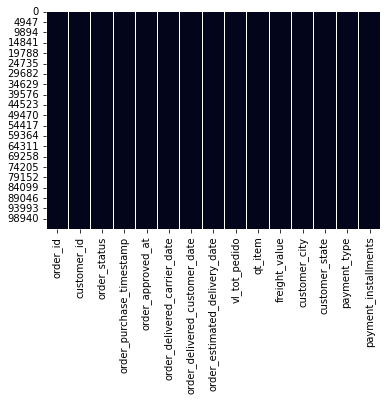

In [83]:
sns.heatmap(ds_pedidos_itens_unicos.isnull(), cbar = False);

In [84]:
ds_pedidos_itens_unicos.query("order_id == '947e9c6bfd83a06953c420ef92d3da6e'")

order_id  ... payment_installments
10928  947e9c6bfd83a06953c420ef92d3da6e  ...                    1

[1 rows x 15 columns]

In [85]:
ds_pedidos_itens_unicos.tail()

order_id  ... payment_installments
103881  9c5dedf39a927c1b2549525ed64a053c  ...                    3
103882  63943bddc261676b46f01ca7ac2f7bd8  ...                    3
103883  83c1379a015df1e13d02aae0204711ab  ...                    5
103884  11c177c8e97725db2631073c19f07b62  ...                    4
103885  66dea50a8b16d9b4dee7af250b4be1a5  ...                    1

[5 rows x 15 columns]

In [86]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

order_id  ... payment_installments
92788  8272b63d03f5f79c56e9e4120aec44ef  ...                    2

[1 rows x 15 columns]

In [87]:
ds_pedidos_itens_unicos["payment_type"] = ds_pedidos_itens_unicos["payment_type"].astype('category')
ds_pedidos_itens_unicos['payment_type_cat'] = ds_pedidos_itens_unicos['payment_type'].cat.codes

### Alteração do formato de datas

In [88]:
ds_pedidos_itens_unicos['ano_venda'] = ds_pedidos_itens_unicos['order_purchase_timestamp']
ds_pedidos_itens_unicos['ano_venda'] = ds_pedidos_itens_unicos['ano_venda'].apply(lambda x: x.year)
ds_pedidos_itens_unicos['ano_venda'] = ds_pedidos_itens_unicos['ano_venda'].astype(int)

In [89]:
ds_pedidos_itens_unicos['mes_venda'] = ds_pedidos_itens_unicos['order_purchase_timestamp']
ds_pedidos_itens_unicos['mes_venda'] = ds_pedidos_itens_unicos['mes_venda'].apply(lambda x: x.month)
ds_pedidos_itens_unicos['mes_venda'] = ds_pedidos_itens_unicos['mes_venda'].astype(int)

In [90]:
ds_pedidos_itens_unicos['dia_venda'] = ds_pedidos_itens_unicos['order_purchase_timestamp']
ds_pedidos_itens_unicos['dia_venda'] = ds_pedidos_itens_unicos['dia_venda'].apply(lambda x: x.day)
ds_pedidos_itens_unicos['dia_venda'] = ds_pedidos_itens_unicos['dia_venda'].astype(int)

In [91]:
ds_pedidos_itens_unicos.corr()

vl_tot_pedido   qt_item  ...  mes_venda  dia_venda
vl_tot_pedido              1.000000  0.150884  ...   0.000794  -0.007485
qt_item                    0.150884  1.000000  ...   0.001011   0.010399
freight_value              0.414520  0.435387  ...   0.003841  -0.008197
payment_installments       0.306152  0.066923  ...   0.029635   0.001416
payment_type_cat          -0.003739 -0.022769  ...  -0.000250   0.003321
ano_venda                 -0.001877  0.002103  ...  -0.547980  -0.043400
mes_venda                  0.000794  0.001011  ...   1.000000   0.002678
dia_venda                 -0.007485  0.010399  ...   0.002678   1.000000

[8 rows x 8 columns]

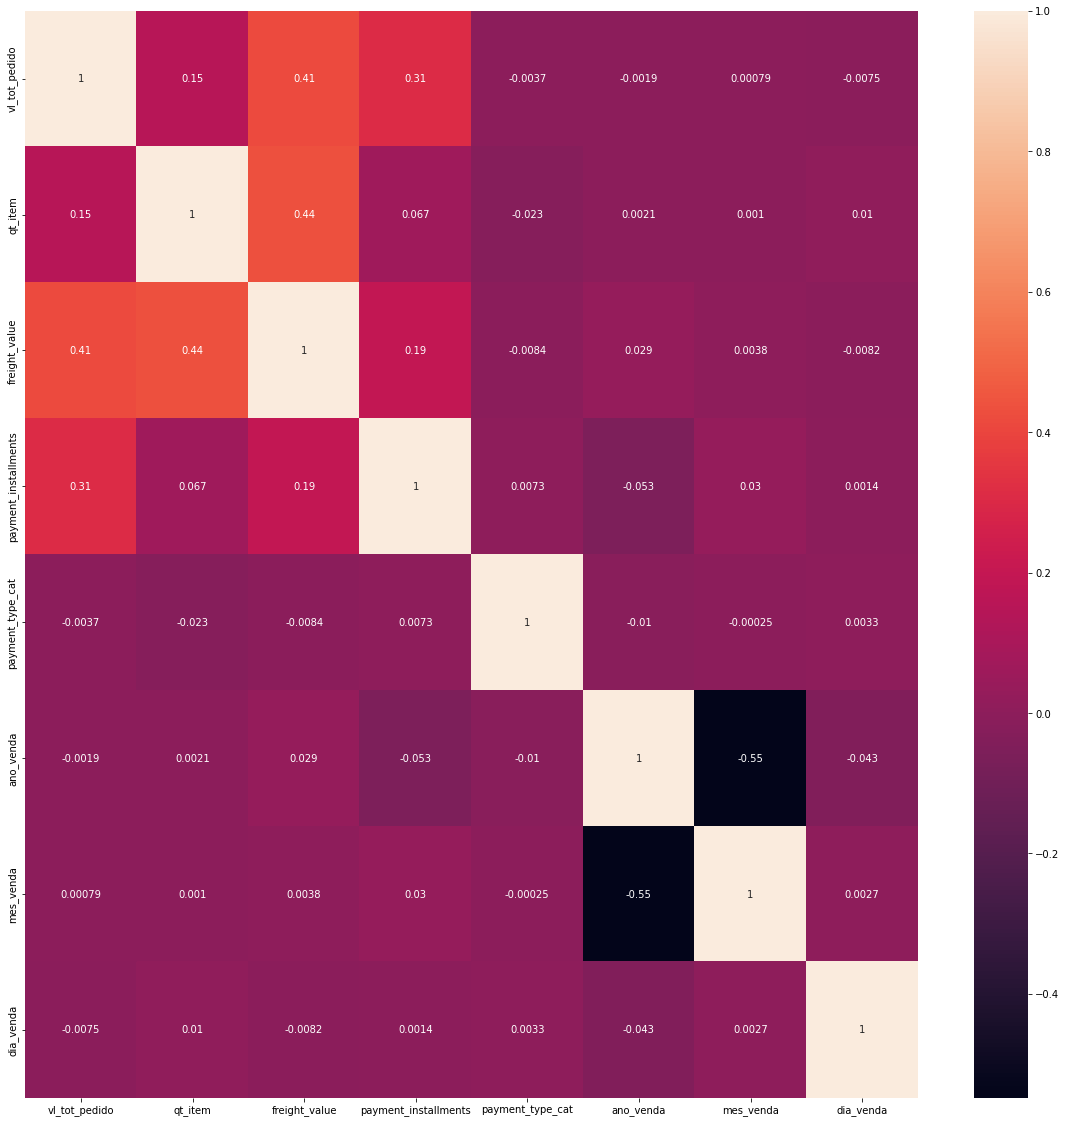

In [92]:
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(ds_pedidos_itens_unicos.corr(), annot = True);

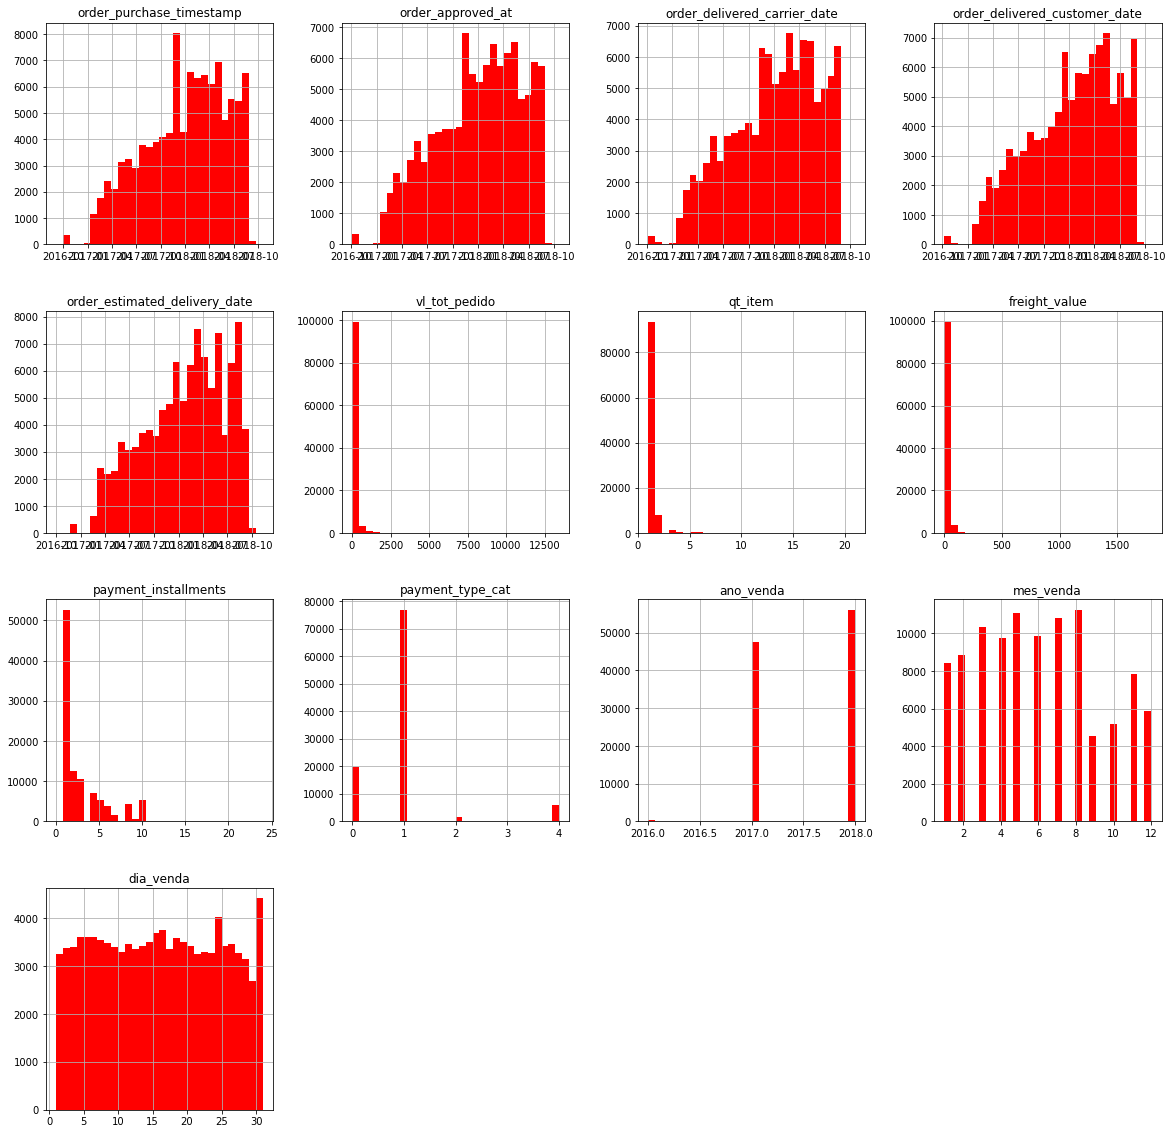

In [93]:
ds_pedidos_itens_unicos.hist(bins = 30, figsize = (20,20), color = 'r');

## Análise boxplot

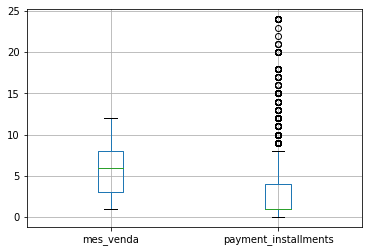

In [94]:
ds_pedidos_itens_unicos[['mes_venda', 'payment_installments']].boxplot()

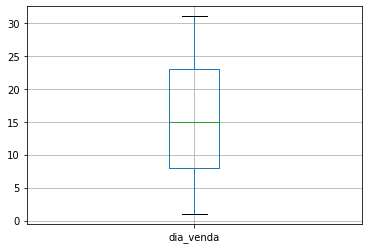

In [95]:
ds_pedidos_itens_unicos[['dia_venda']].boxplot()

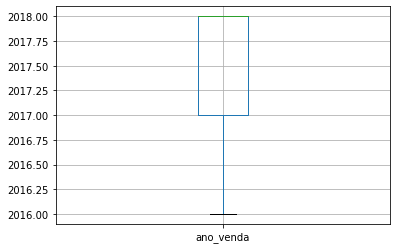

In [96]:
ds_pedidos_itens_unicos[['ano_venda']].boxplot()

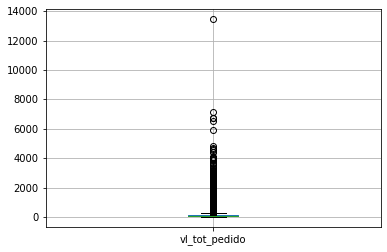

In [97]:
ds_pedidos_itens_unicos[['vl_tot_pedido']].boxplot()

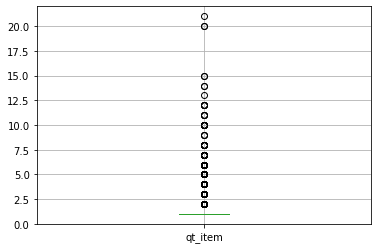

In [98]:
ds_pedidos_itens_unicos[['qt_item']].boxplot()

## Analise dos pedidos com apenas um produto vs pedidos com mais de um produto

In [99]:
pedido_unico_produto = ds_pedidos_itens_unicos.query('qt_item == 1')['qt_item'].count()
tota_pedidos = ds_pedidos_itens_unicos['qt_item'].count()
print('Nº de pedidos com apenas um item: {0}'.format(pedido_unico_produto))
print('\nNº de pedidos com mais de um item: {0}'.format(tota_pedidos - pedido_unico_produto))

Nº de pedidos com apenas um item: 93648

Nº de pedidos com mais de um item: 10238


In [100]:
percentual_pedido_unico_item = (pedido_unico_produto / tota_pedidos) * 100;
percentual_pedido_cliente = (total_clientes_unico / pedido_unico_produto) ;
#print('{0} clientes fazem compras de apenas um único produto por pedido.'.format(total_clientes_unico))
print('% de pedidos com apenas um único produto: {0}%'.format(round(percentual_pedido_unico_item, 2)))
print('\nProporção de pedidos com apenas um único produto por cliente: {0}'.format(round(percentual_pedido_cliente, 2)))
print('\nPodemos concluir que não há compra com item combinado, o percentual é baixo para esta estratégia.')

% de pedidos com apenas um único produto: 90.14%

Proporção de pedidos com apenas um único produto por cliente: 1.03

Podemos concluir que não há compra com item combinado, o percentual é baixo para esta estratégia.


In [101]:
quant_frete_pago = ds_pedido_frete_pago['vl_tot_pedido'].count()
print('Dos {0} pedidos com apenas 1 item, {1}% deles são de fretes pagos, de um total de {2}.'.format(pedido_unico_produto, 
                                                                                                     round((pedido_unico_produto / quant_frete_pago * 100), 2),
                                                                                                    quant_frete_pago))

Dos 93648 pedidos com apenas 1 item, 95.24% deles são de fretes pagos, de um total de 98328.


## Os estados do Norte tem pouca ou nenhuma vendas, enquanto o Sudeste lidera em nº de pedidos

In [102]:
ds_cidade_pedido = ds_pedidos_itens_unicos.groupby('customer_state')['order_id'].count()
ds_cidade_pedido.reset_index()
ds_cidade_pedido.head()

customer_state
AC      84
AL     427
AM     154
AP      70
BA    3610
Name: order_id, dtype: int64

## Estados que Mais Geraram Pedidos

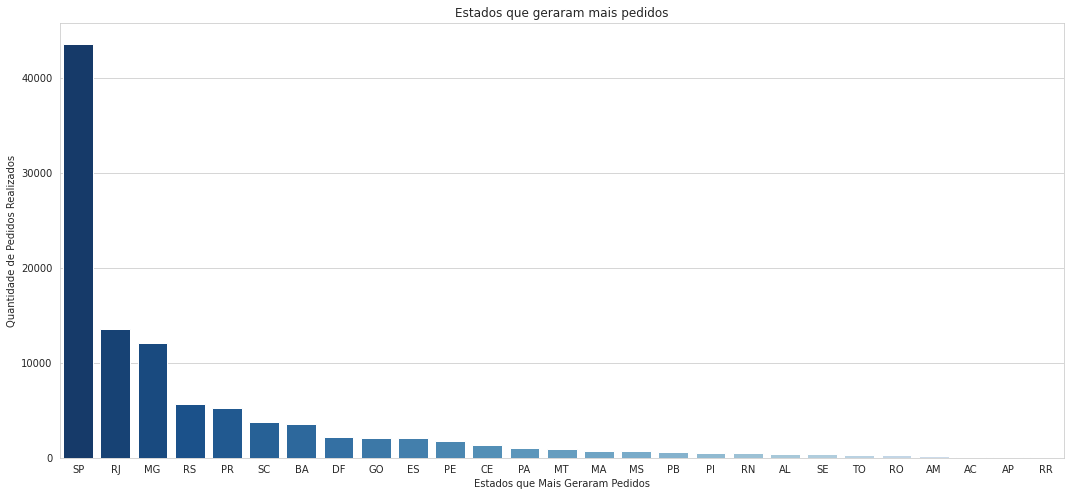

In [103]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))
plt.title("Estados que geraram mais pedidos")

ds_cidade_pedido = ds_cidade_pedido.sort_values(ascending=False)
sns.barplot(x=ds_cidade_pedido.index,
            y=ds_cidade_pedido.values,
            palette=sns.color_palette("Blues_r", n_colors=len(ds_cidade_pedido) + 4)).set(
    xlabel='Estados que Mais Geraram Pedidos',
    ylabel='Quantidade de Pedidos Realizados'
)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

In [104]:
ds_cliente_pedido = ds_pedidos_itens_unicos.query('qt_item > 1.0').groupby('customer_state')['order_id'].count()
ds_cliente_pedido.reset_index()
ds_cliente_pedido.head()

customer_state
AC      5
AL     24
AM     10
AP     10
BA    332
Name: order_id, dtype: int64

## Estados que Geraram Pedidos com Mais de um Item

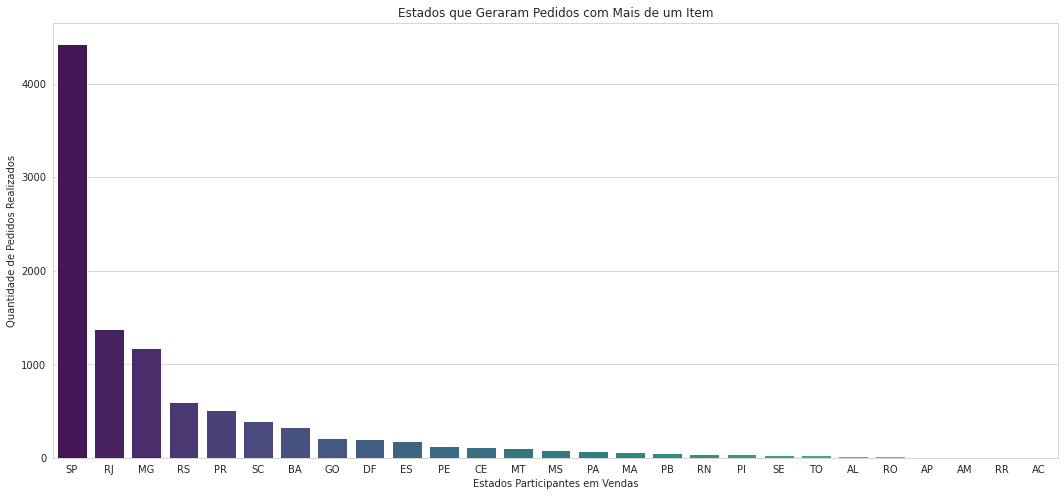

In [105]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))
plt.title("Estados que Geraram Pedidos com Mais de um Item")

ds_cliente_pedido = ds_cliente_pedido.sort_values(ascending=False)
sns.barplot(x=ds_cliente_pedido.index,
            y=ds_cliente_pedido.values,
            palette=sns.color_palette("viridis", n_colors=len(ds_cliente_pedido) + 3)).set(
    xlabel='Estados Participantes em Vendas',
    ylabel='Quantidade de Pedidos Realizados'
)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

## As 10 cidades com Maior Valor em Vendas

In [106]:
ds_cidade_valor_vendas = ds_pedidos_itens_unicos.groupby(['customer_city'])['vl_tot_pedido'].sum()
ds_cidade_valor_vendas.reset_index()
ds_cidade_valor_vendas.head()

customer_city
abadia dos dourados     358.90
abadiania               949.99
abaete                 1732.81
abaetetuba             4058.47
abaiara                 262.90
Name: vl_tot_pedido, dtype: float64

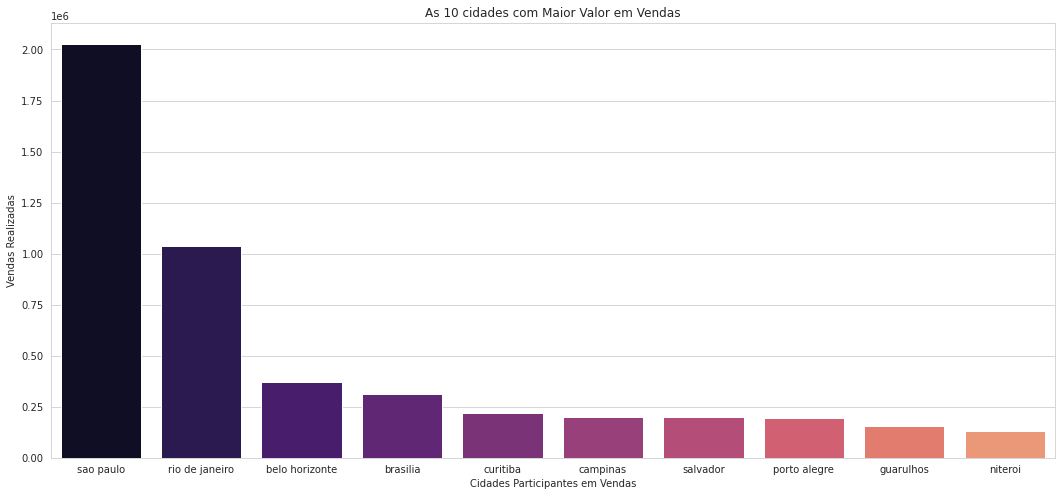

In [209]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))
plt.title("As 10 cidades com Maior Valor em Vendas")

ds_cidade_valor_vendas = ds_cidade_valor_vendas.sort_values(ascending=False)

ds_cidade_valor_vendas = ds_cidade_valor_vendas.iloc[0:10]

sns.barplot(x=ds_cidade_valor_vendas.index,
            y=ds_cidade_valor_vendas.values,
            palette=sns.color_palette("magma", n_colors=len(ds_cidade_valor_vendas) + 2)).set(
    xlabel='Cidades Participantes em Vendas',
    ylabel='Vendas Realizadas'
)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

## As 10 cidades com o maior nº de pedidos

#### A 10ª cidade (São Bernardo do Campo) com o maior nº de pedidos não é a cidade com o maior valor em vendas, nesta amostra, a 10ª posição é de Niterói.

In [108]:
ds_cidade_pedidos = ds_pedidos_itens_unicos.groupby(['customer_city'])['order_id'].count()
ds_cidade_pedidos.reset_index()
ds_cidade_pedidos.head()

customer_city
abadia dos dourados     3
abadiania               1
abaete                 12
abaetetuba             12
abaiara                 2
Name: order_id, dtype: int64

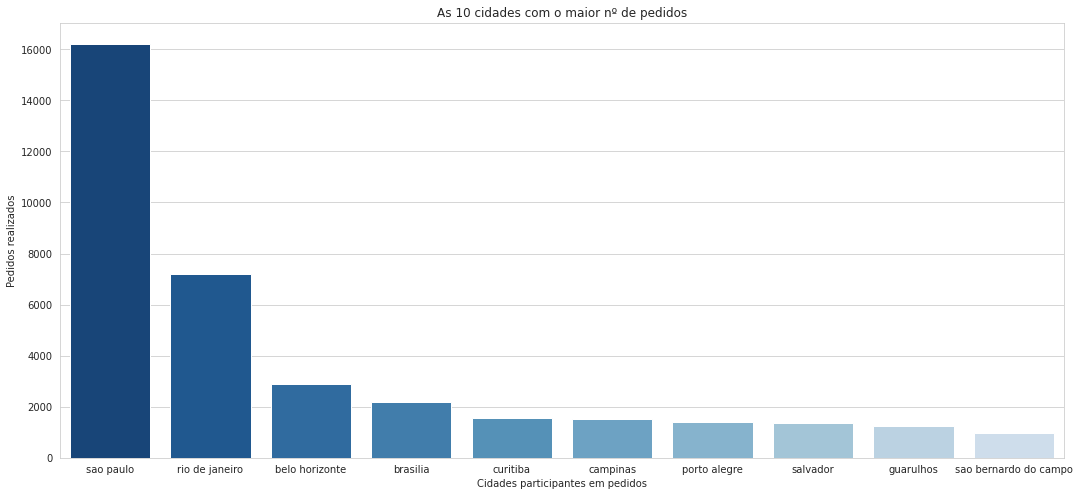

In [109]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))
plt.title("As 10 cidades com o maior nº de pedidos")

ds_cidade_pedidos = ds_cidade_pedidos.sort_values(ascending=False)

ds_cidade_pedidos = ds_cidade_pedidos.iloc[0:10]

sns.barplot(x=ds_cidade_pedidos.index,
            y=ds_cidade_pedidos.values,
            palette=sns.color_palette("Blues_r", n_colors=len(ds_cidade_pedidos) + 2)).set(
    xlabel='Cidades participantes em pedidos',
    ylabel='Pedidos realizados'
)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

## Os 10 Estados com Maior Valor em Vendas

In [110]:
ds_estado_vendas = ds_pedidos_itens_unicos.groupby('customer_state')['vl_tot_pedido'].sum()
ds_estado_vendas.reset_index()
ds_estado_vendas.head()

customer_state
AC     17059.44
AL     83385.86
AM     22947.11
AP     13654.30
BA    544579.45
Name: vl_tot_pedido, dtype: float64

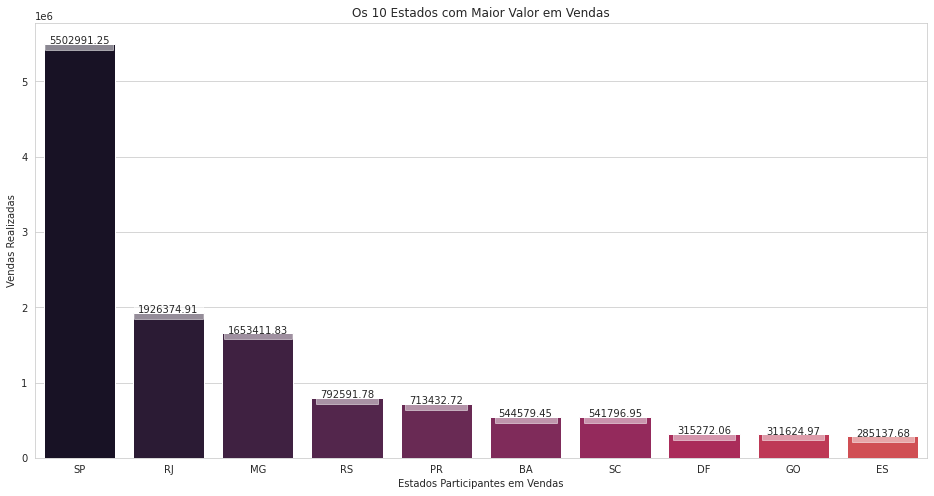

In [111]:
sns.set_style("whitegrid")

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
            bbox = dict(facecolor = 'white', alpha = .5))

plt.figure(figsize=(16,8))
plt.title("Os 10 Estados com Maior Valor em Vendas")

ds_estado_vendas = ds_estado_vendas.sort_values(ascending=False)

ds_estado_vendas = ds_estado_vendas.iloc[0:10]

sns.barplot(x=ds_estado_vendas.index,
            y=ds_estado_vendas.values,
            palette=sns.color_palette("rocket", n_colors=len(ds_estado_vendas) + 6)).set(
    xlabel='Estados Participantes em Vendas',
    ylabel='Vendas Realizadas'
)

addlabels(ds_estado_vendas.index, ds_estado_vendas.values)
locs, labels = plt.xticks()
plt.setp(labels, rotation=0, horizontalalignment='center')
plt.show()

In [112]:
ds_estado_status_logistica = ds_pedidos_itens_unicos.groupby('order_status')['customer_state'].count()
ds_estado_status_logistica.reset_index()
ds_estado_status_logistica = ds_estado_status_logistica.sort_values(ascending=False)
ds_estado_status_logistica.head()

order_status
delivered      100756
shipped          1166
canceled          664
unavailable       649
invoiced          325
Name: customer_state, dtype: int64

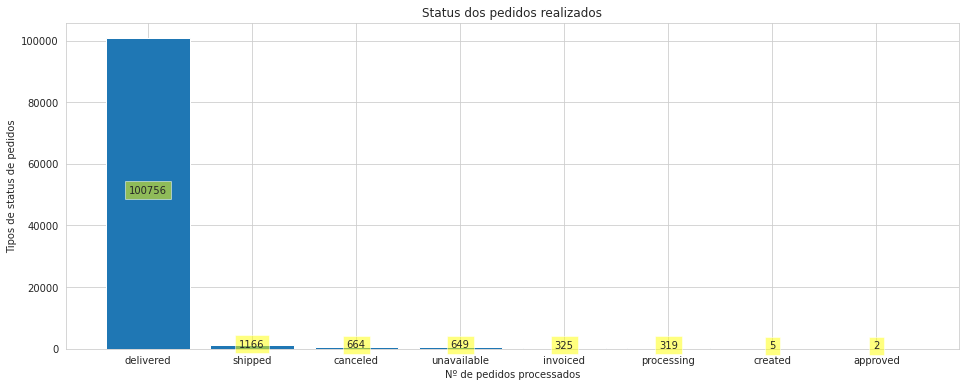

In [113]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',
            bbox = dict(facecolor = 'yellow', alpha = .5))
  
if __name__ == '__main__':

    x = ds_estado_status_logistica.index
    y = ds_estado_status_logistica.values

    plt.figure(figsize = (16,6))

    plt.bar(x, y)

    addlabels(x, y)
    
    plt.title("Status dos pedidos realizados")
    plt.xlabel('Nº de pedidos processados')
    plt.ylabel('Tipos de status de pedidos')
    plt.show()

In [114]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

order_id  ... dia_venda
92788  8272b63d03f5f79c56e9e4120aec44ef  ...        16

[1 rows x 19 columns]

In [115]:
ds_produtos_pedidos = ds_pedidos_itens_unicos[['order_id', 'customer_city', 'customer_state']]
ds_produtos_pedidos.head()

order_id customer_city customer_state
0  e481f51cbdc54678b7cc49136f2d6af7     sao paulo             SP
1  e481f51cbdc54678b7cc49136f2d6af7     sao paulo             SP
2  e481f51cbdc54678b7cc49136f2d6af7     sao paulo             SP
3  53cdb2fc8bc7dce0b6741e2150273451     barreiras             BA
4  47770eb9100c2d0c44946d9cf07ec65d    vianopolis             GO

In [116]:
ds_pedido_itens

order_id  order_item_id  ...   price freight_value
0       00010242fe8c5a6d1ba2dd792cb16214              1  ...   58.90         13.29
1       00018f77f2f0320c557190d7a144bdd3              1  ...  239.90         19.93
2       000229ec398224ef6ca0657da4fc703e              1  ...  199.00         17.87
3       00024acbcdf0a6daa1e931b038114c75              1  ...   12.99         12.79
4       00042b26cf59d7ce69dfabb4e55b4fd9              1  ...  199.90         18.14
...                                  ...            ...  ...     ...           ...
112645  fffc94f6ce00a00581880bf54a75a037              1  ...  299.99         43.41
112646  fffcd46ef2263f404302a634eb57f7eb              1  ...  350.00         36.53
112647  fffce4705a9662cd70adb13d4a31832d              1  ...   99.90         16.95
112648  fffe18544ffabc95dfada21779c9644f              1  ...   55.99          8.72
112649  fffe41c64501cc87c801fd61db3f6244              1  ...   43.00         12.79

[112650 rows x 7 columns]

In [117]:
ds_produtos_pedidos = ds_produtos_pedidos.merge(ds_pedido_itens, on = "order_id", how = "left")
ds_produtos_pedidos.reset_index()
ds_produtos_pedidos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

order_id customer_city  ... price  freight_value
105651  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105652  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105653  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105654  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105655  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105656  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105657  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105658  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105659  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105660  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105661  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105662  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105663  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105664  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105665  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105666  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105667  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105668  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105669  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105670  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   1.2           7.89
105671  8272b63d03f5f79c56e9e4120aec44ef     sao paulo  ...   7.8           6.57

[21 rows x 9 columns]

In [118]:
ds_produtos_pedidos.columns

Index(['order_id', 'customer_city', 'customer_state', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value'],
      dtype='object')

In [119]:
ds_produtos_categoria = ds_produtos[['product_id', 'product_category_name']]
ds_produtos_categoria.head()

product_id  product_category_name
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer
3  cef67bcfe19066a932b7673e239eb23d                  bebes
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas

In [120]:
ds_pedido_status = ds_pedidos_itens_unicos[['order_id','order_status']]
ds_produtos_pedidos = ds_produtos_pedidos.merge(ds_produtos_categoria, on = "product_id", how = "left")
ds_produtos_pedidos.reset_index()
ds_produtos_pedidos = ds_produtos_pedidos.merge(ds_pedido_status, on = "order_id", how = "left")
ds_produtos_pedidos.reset_index()
ds_produtos_pedidos.head()

order_id  ... order_status
0  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered
1  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered
2  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered
3  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered
4  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered

[5 rows x 11 columns]

In [121]:
ds_produtos_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140561 entries, 0 to 140560
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               140561 non-null  object 
 1   customer_city          140561 non-null  object 
 2   customer_state         140561 non-null  object 
 3   order_item_id          139417 non-null  float64
 4   product_id             139417 non-null  object 
 5   seller_id              139417 non-null  object 
 6   shipping_limit_date    139417 non-null  object 
 7   price                  139417 non-null  float64
 8   freight_value          139417 non-null  float64
 9   product_category_name  137243 non-null  object 
 10  order_status           140561 non-null  object 
dtypes: float64(3), object(8)
memory usage: 12.9+ MB


In [122]:
ds_produtos_pedidos.isnull().sum()

order_id                    0
customer_city               0
customer_state              0
order_item_id            1144
product_id               1144
seller_id                1144
shipping_limit_date      1144
price                    1144
freight_value            1144
product_category_name    3318
order_status                0
dtype: int64

In [123]:
ds_produtos_pedidos = ds_produtos_pedidos.dropna()
ds_produtos_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137243 entries, 0 to 140560
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               137243 non-null  object 
 1   customer_city          137243 non-null  object 
 2   customer_state         137243 non-null  object 
 3   order_item_id          137243 non-null  float64
 4   product_id             137243 non-null  object 
 5   seller_id              137243 non-null  object 
 6   shipping_limit_date    137243 non-null  object 
 7   price                  137243 non-null  float64
 8   freight_value          137243 non-null  float64
 9   product_category_name  137243 non-null  object 
 10  order_status           137243 non-null  object 
dtypes: float64(3), object(8)
memory usage: 12.6+ MB


In [124]:
ds_produtos_pedidos.head()

order_id  ... order_status
0  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered
1  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered
2  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered
3  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered
4  e481f51cbdc54678b7cc49136f2d6af7  ...    delivered

[5 rows x 11 columns]

In [125]:
ds_produtos_pedidos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

order_id  ... order_status
125327  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125328  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125329  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125330  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125331  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125332  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125333  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125334  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125335  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125336  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125337  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125338  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125339  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125340  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125341  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125342  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125343  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125344  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125345  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125346  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered
125347  8272b63d03f5f79c56e9e4120aec44ef  ...    delivered

[21 rows x 11 columns]

# *É necessário análise das categorias de produtos*

### Tranformando atributos textuais em categóricos

In [126]:
#ds_pedidos_itens_unicos["order_status"] = ds_pedidos_itens_unicos["order_status"].astype('category')
#ds_pedidos_itens_unicos['order_status_cat'] = ds_pedidos_itens_unicos['order_status'].cat.codes

In [127]:
#ds_reviews.head()

In [128]:
#ds_categorias.head()

In [129]:
#ds_produtos_pedidos_dummies = pd.get_dummies(ds_produtos_pedidos, columns=['product_category_name'])
#ds_produtos_pedidos_dummies.head()

In [130]:
#ds_produtos.head()

In [131]:
#ds_pedidos_itens_unicos["seller_state"] = ds_pedidos_itens_unicos["seller_state"].astype('category')
#ds_pedidos_itens_unicos['seller_state_cat'] = ds_pedidos_itens_unicos['seller_state'].cat.codes

In [132]:
#ds_pedidos_itens_unicos["customer_state"] = ds_pedidos_itens_unicos["customer_state"].astype('category')
#ds_pedidos_itens_unicos['customer_state_cat'] = ds_pedidos_itens_unicos['customer_state'].cat.codes

In [133]:
#ds_pedidos_itens_unicos.head()

## Os 15 Vendedores com Mais Vendas Realizadas

In [134]:
ds_vendedor_pedido = ds_produtos_pedidos[['seller_id', 'order_id', 'price', 'product_category_name', 'order_status']]

ds_vendedor_pedido = ds_vendedores[['seller_id', 'seller_city', 'seller_state']].merge(ds_vendedor_pedido, on = "seller_id", how = "left")

ds_vendedor_pedido.reset_index()

ds_vendedor_pedido = ds_vendedor_pedido.dropna()


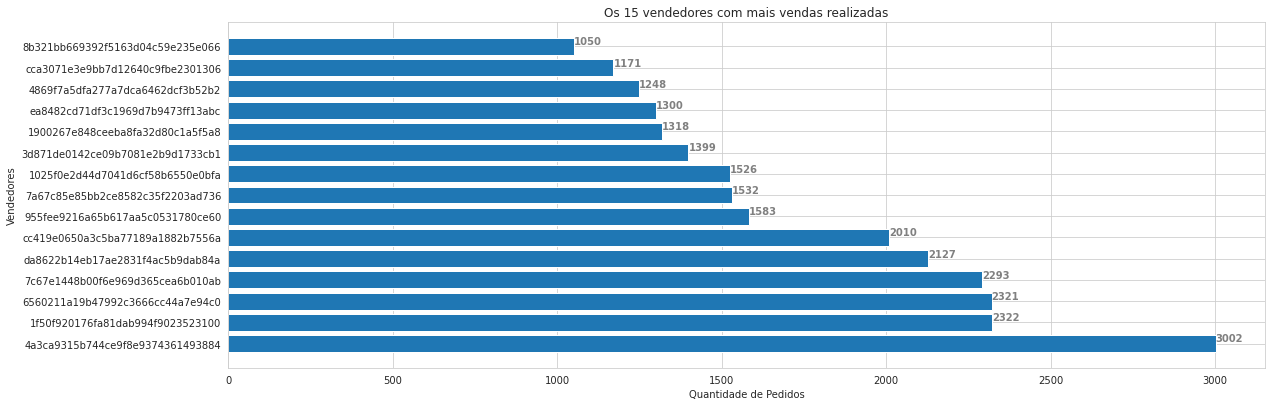

In [135]:
ds_vendedor_pedido_melhores = ds_vendedor_pedido.query('order_status == "delivered"').groupby('seller_id')['order_id'].count()

ds_vendedor_pedido_melhores.reset_index()

ds_vendedor_pedido_melhores = ds_vendedor_pedido_melhores.sort_values(ascending=False)

ds_vendedor_pedido_melhores = ds_vendedor_pedido_melhores.iloc[0:15]

fig= plt.figure(figsize=(18,6))

axes= fig.add_axes([0.1,0.1,0.8,0.8])

plt.title("Os 15 vendedores com mais vendas realizadas")
plt.xlabel('Quantidade de Pedidos')
plt.ylabel('Vendedores')
axes.barh(ds_vendedor_pedido_melhores.index, ds_vendedor_pedido_melhores.values, align='center', alpha=1.0)

for i in axes.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.show()

## Os 15 Maiores Vendedores e o Valor Médio de Vendas

In [136]:
ds_media_valores_vendedor_pedido = ds_vendedor_pedido[['seller_id', 'price', 'product_category_name']]

ds_vendedor_pedido_melhores = pd.DataFrame(ds_vendedor_pedido_melhores)

ds_media_valores_vendedor_pedido = ds_media_valores_vendedor_pedido.merge(ds_vendedor_pedido_melhores, on = "seller_id", how = "left")

ds_media_valores_vendedor_pedido.reset_index()

ds_media_valores_vendedor_pedido = ds_media_valores_vendedor_pedido.dropna()

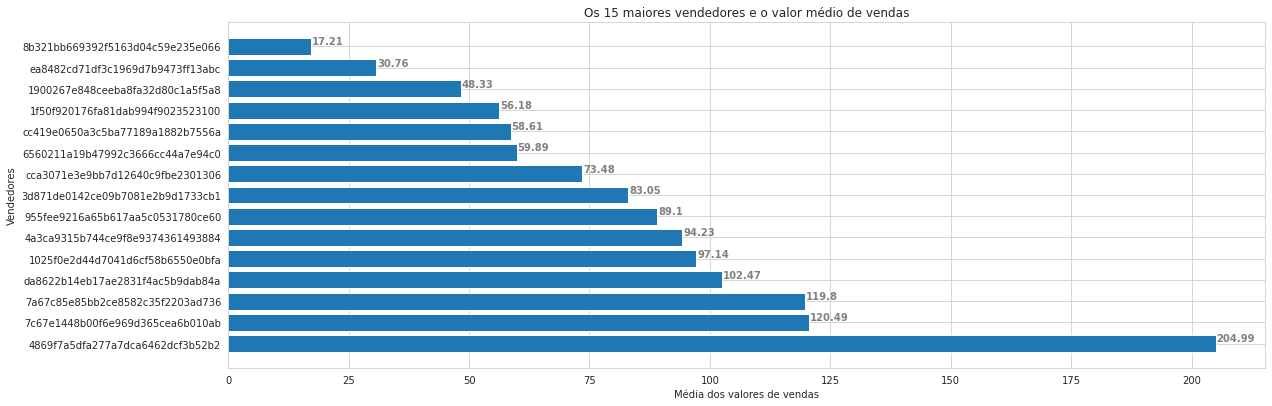

In [137]:
ds_media_valores_vendedor = ds_media_valores_vendedor_pedido.groupby('seller_id')['price'].mean()

ds_media_valores_vendedor.reset_index()

ds_media_valores_vendedor = ds_media_valores_vendedor.sort_values(ascending=False)

fig= plt.figure(figsize=(18,6))

axes= fig.add_axes([0.1,0.1,0.8,0.8])

plt.title("Os 15 maiores vendedores e o valor médio de vendas")
plt.xlabel('Média dos valores de vendas')
plt.ylabel('Vendedores')
axes.barh(ds_media_valores_vendedor.index, ds_media_valores_vendedor.values, align='center', alpha=1.0)

for i in axes.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
    
plt.show()

## As 15 Categorias Mais Vendidas pelos Melhores Vendedores

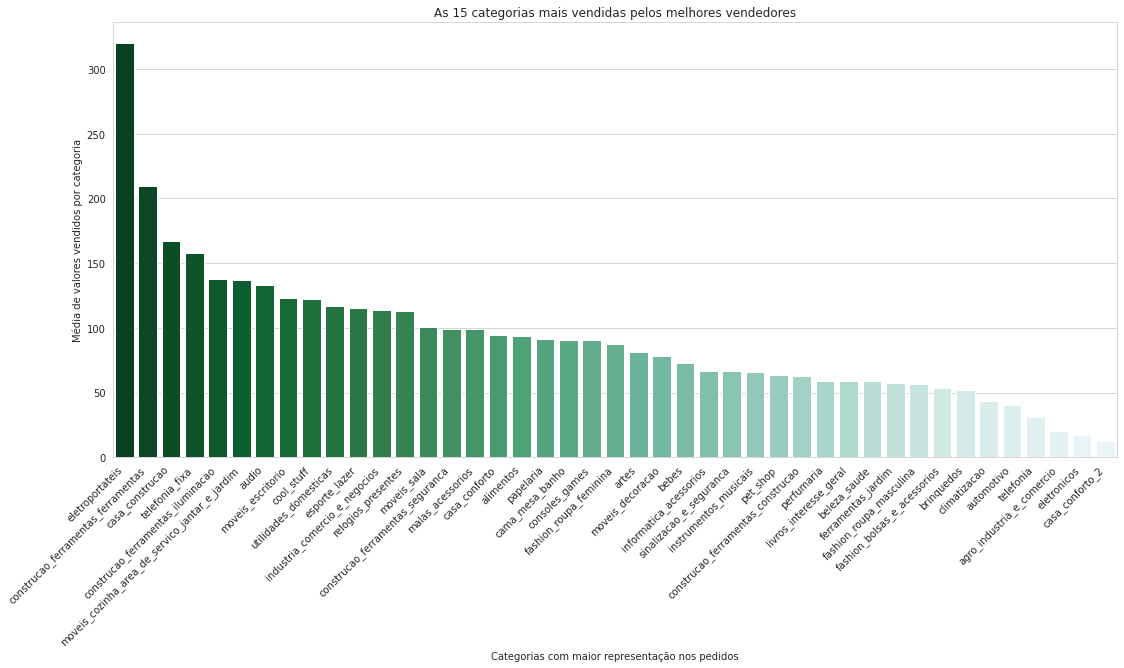

In [138]:
ds_media_valores_categoria = ds_media_valores_vendedor_pedido.groupby('product_category_name')['price'].mean()

ds_media_valores_categoria.reset_index()

ds_media_valores_categoria = ds_media_valores_categoria.sort_values(ascending=False)

sns.set_style("whitegrid")
plt.figure(figsize=(18,8))

sns.barplot(x=ds_media_valores_categoria.index,
            y=ds_media_valores_categoria.values,
            palette=sns.color_palette("BuGn_r", n_colors=len(ds_media_valores_categoria) + 4))
locs, labels = plt.xticks()
plt.title("As 15 categorias mais vendidas pelos melhores vendedores")
plt.xlabel('Categorias com maior representação nos pedidos')
plt.ylabel('Média de valores vendidos por categoria')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

## Categorias Mais Vendidas

In [139]:
ds_produtos_categorias_vendidos = ds_produtos_pedidos.groupby('product_category_name')['product_id'].count()

ds_produtos_categorias_vendidos.reset_index()

ds_produtos_categorias_vendidos.head()

product_category_name
agro_industria_e_comercio    736
alimentos                    578
alimentos_bebidas            313
artes                        243
artes_e_artesanato            24
Name: product_id, dtype: int64

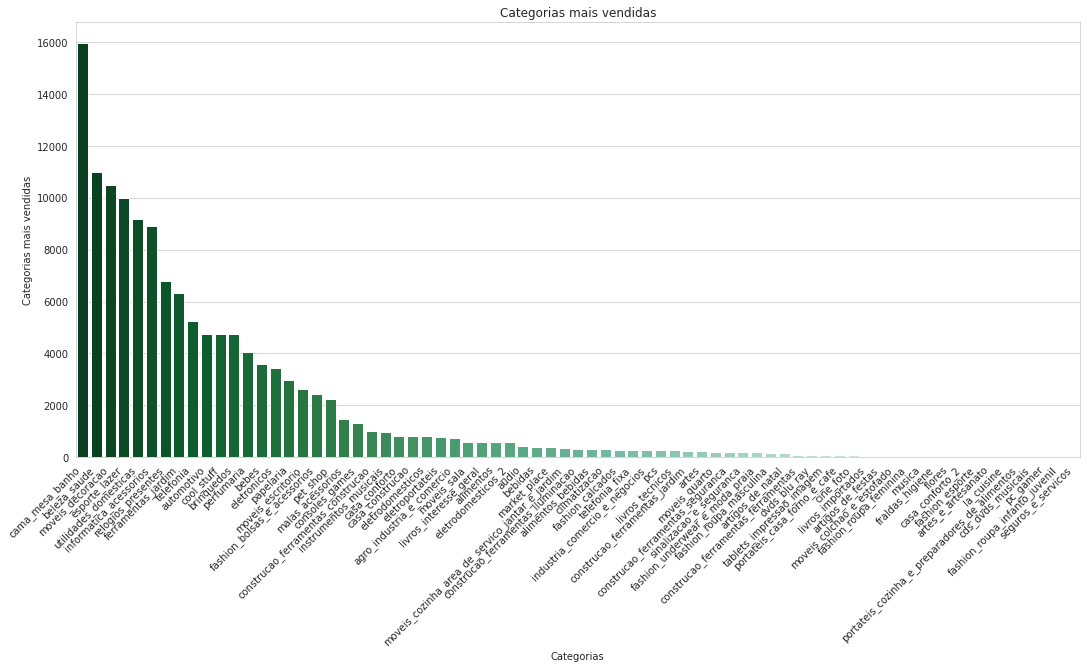

In [140]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))

ds_produtos_categorias_vendidos = ds_produtos_categorias_vendidos.sort_values(ascending=False)

sns.barplot(x=ds_produtos_categorias_vendidos.index,
            y=ds_produtos_categorias_vendidos.values,
            palette=sns.color_palette("BuGn_r", n_colors=len(ds_produtos_categorias_vendidos) + 4))
locs, labels = plt.xticks()
plt.title("Categorias mais vendidas")
plt.xlabel('Categorias')
plt.ylabel('Categorias mais vendidas')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

## As Categorias Mais Vendidas nos 5 Estados com Melhor Resultado em Vendas

In [141]:
#ds_produtos_pedidos.groupby(['customer_state', 'product_category_name'])['product_category_name'].count().plot(kind='bar', color='g', rot = 45, position = -1.5, figsize = (16, 12), layout=(3,4), align='center');
ds_produtos_pedidos_estados = ds_produtos_pedidos.query('customer_state == "SP" or customer_state == "RJ" or customer_state == "MG" or customer_state == "RS" or customer_state == "PR" or customer_state == "SC" or customer_state == "BA"')
ds_produtos_pedidos_estados = ds_produtos_pedidos_estados.groupby(['customer_state', 'product_category_name'])['product_category_name'].count()
ds_produtos_pedidos_estados = ds_produtos_pedidos_estados.sort_values(ascending=False)
ds_produtos_pedidos_estados

customer_state  product_category_name        
SP              cama_mesa_banho                  8288
                moveis_decoracao                 4892
                beleza_saude                     4714
                utilidades_domesticas            4588
                esporte_lazer                    4449
                                                 ... 
BA              fashion_roupa_feminina              1
SC              artes_e_artesanato                  1
RS              pc_gamer                            1
BA              fraldas_higiene                     1
                fashion_roupa_infanto_juvenil       1
Name: product_category_name, Length: 470, dtype: int64

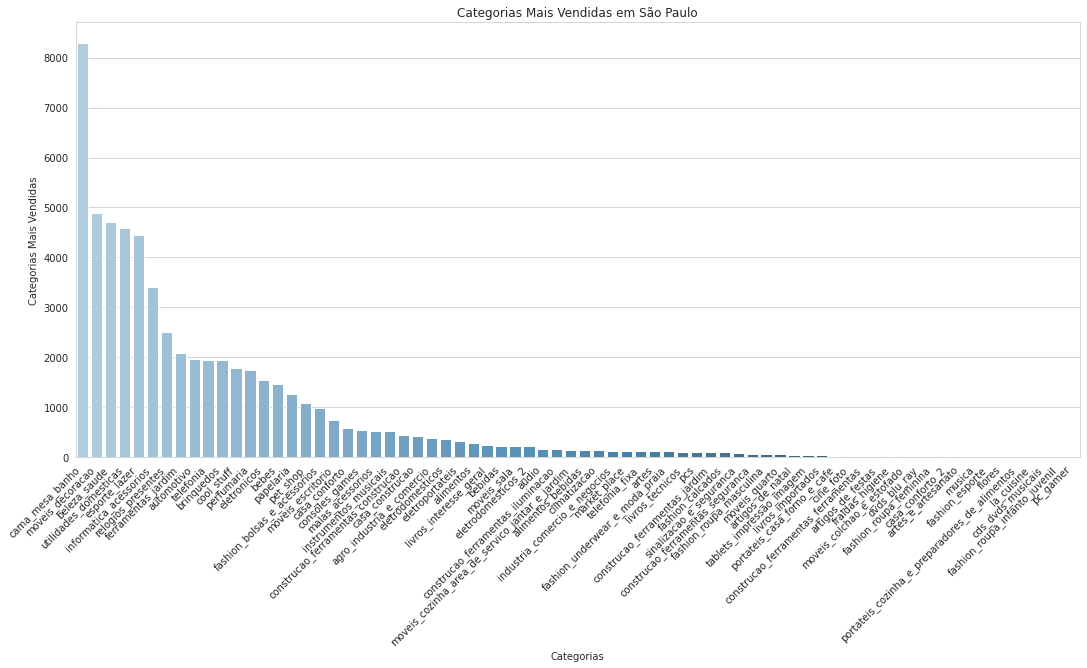

In [142]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))

sns.barplot(x=ds_produtos_pedidos_estados['SP'].index,
            y=ds_produtos_pedidos_estados['SP'].values,
            palette=sns.color_palette("Blues_d", n_colors=len(ds_produtos_pedidos_estados['SP']) + 4))
locs, labels = plt.xticks()
plt.title("Categorias Mais Vendidas em São Paulo")
plt.xlabel('Categorias')
plt.ylabel('Categorias Mais Vendidas')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

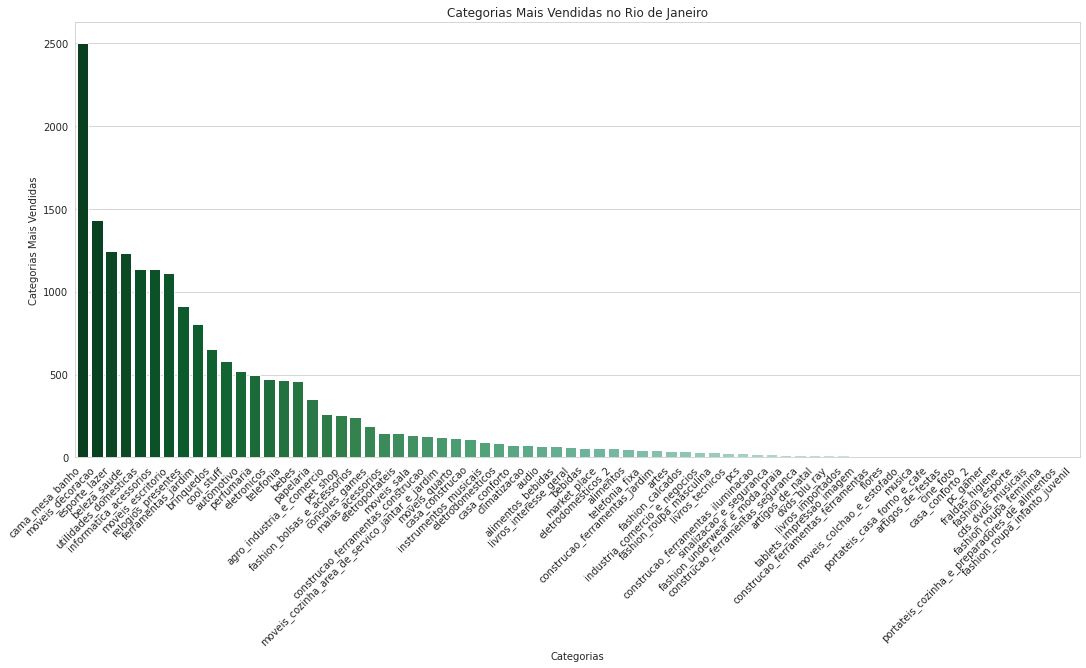

In [143]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))

sns.barplot(x=ds_produtos_pedidos_estados['RJ'].index,
            y=ds_produtos_pedidos_estados['RJ'].values,
            palette=sns.color_palette("BuGn_r", n_colors=len(ds_produtos_pedidos_estados['RJ']) + 4))
locs, labels = plt.xticks()
plt.title("Categorias Mais Vendidas no Rio de Janeiro")
plt.xlabel('Categorias')
plt.ylabel('Categorias Mais Vendidas')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

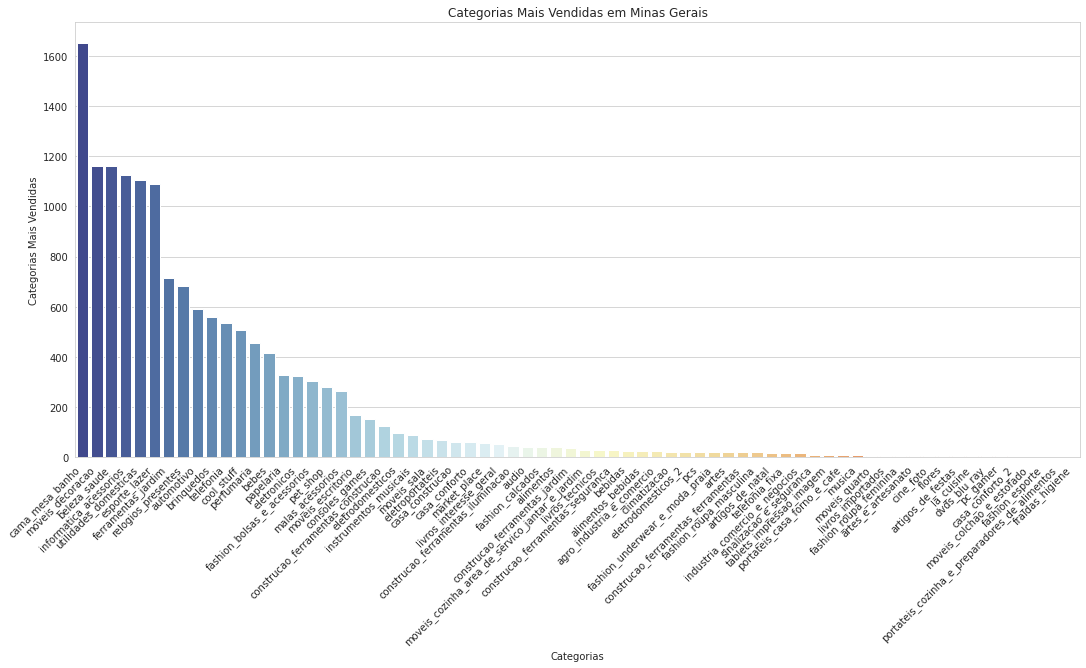

In [144]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))

sns.barplot(x=ds_produtos_pedidos_estados['MG'].index,
            y=ds_produtos_pedidos_estados['MG'].values,
            palette=sns.color_palette("RdYlBu_r", n_colors=len(ds_produtos_pedidos_estados['MG']) + 4))
locs, labels = plt.xticks()
plt.title("Categorias Mais Vendidas em Minas Gerais")
plt.xlabel('Categorias')
plt.ylabel('Categorias Mais Vendidas')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

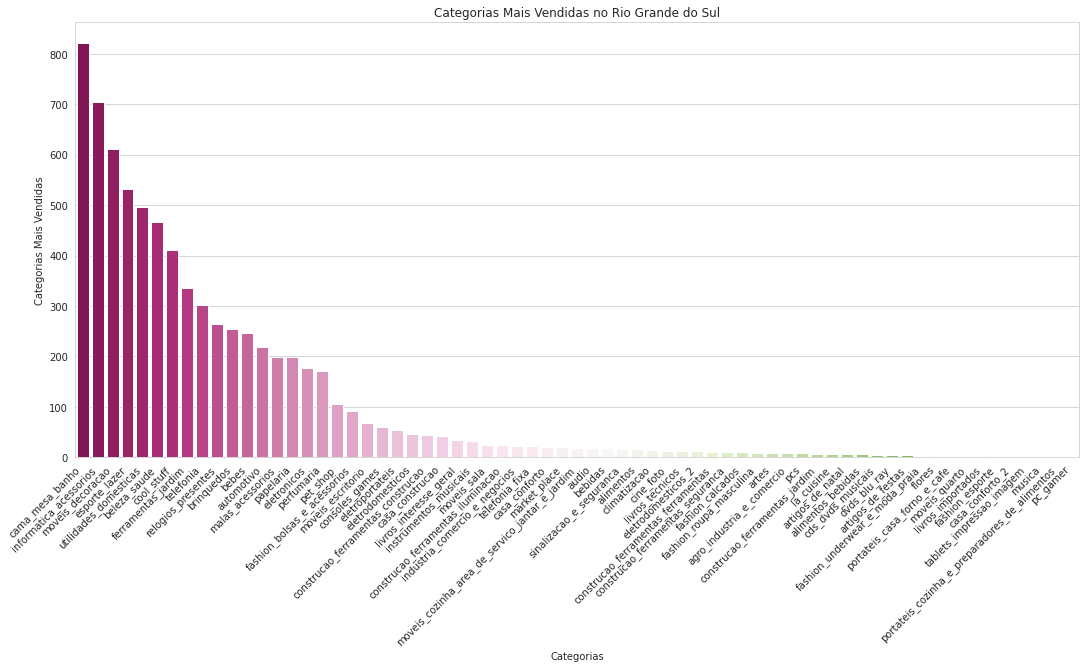

In [145]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))

sns.barplot(x=ds_produtos_pedidos_estados['RS'].index,
            y=ds_produtos_pedidos_estados['RS'].values,
            palette=sns.color_palette("PiYG", n_colors=len(ds_produtos_pedidos_estados['RS']) + 4))
locs, labels = plt.xticks()
plt.title("Categorias Mais Vendidas no Rio Grande do Sul")
plt.xlabel('Categorias')
plt.ylabel('Categorias Mais Vendidas')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

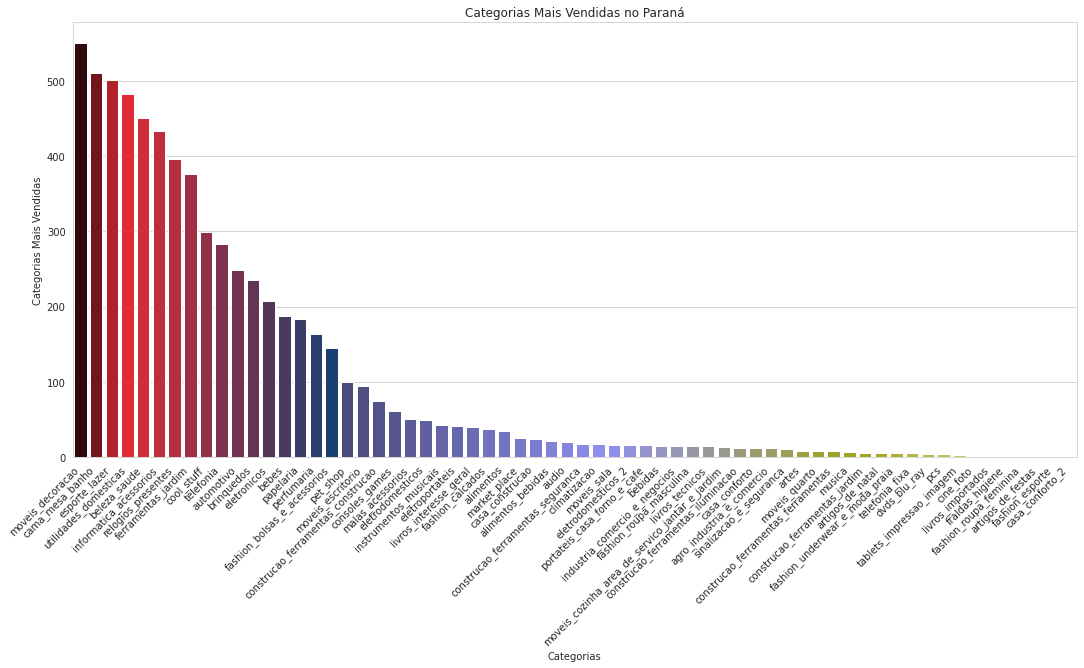

In [146]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))

sns.barplot(x=ds_produtos_pedidos_estados['PR'].index,
            y=ds_produtos_pedidos_estados['PR'].values,
            palette=sns.color_palette("gist_stern", n_colors=len(ds_produtos_pedidos_estados['PR']) + 4))
locs, labels = plt.xticks()
plt.title("Categorias Mais Vendidas no Paraná")
plt.xlabel('Categorias')
plt.ylabel('Categorias Mais Vendidas')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

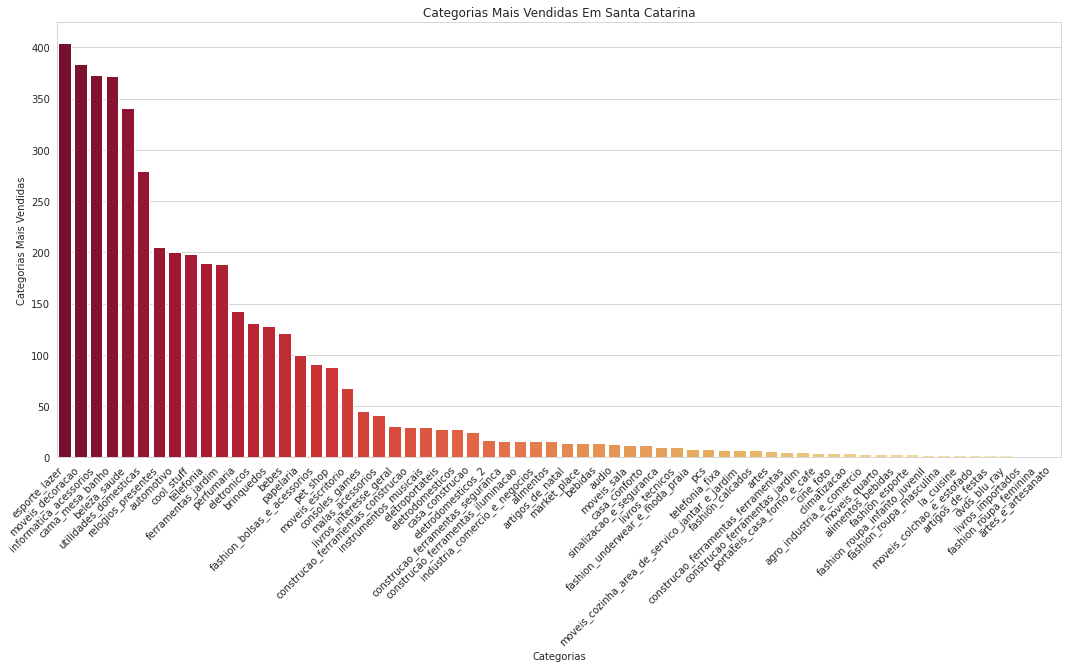

In [147]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))

sns.barplot(x=ds_produtos_pedidos_estados['SC'].index,
            y=ds_produtos_pedidos_estados['SC'].values,
            palette=sns.color_palette("YlOrRd_r", n_colors=len(ds_produtos_pedidos_estados['SC']) + 4))
locs, labels = plt.xticks()
plt.title("Categorias Mais Vendidas Em Santa Catarina")
plt.xlabel('Categorias')
plt.ylabel('Categorias Mais Vendidas')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

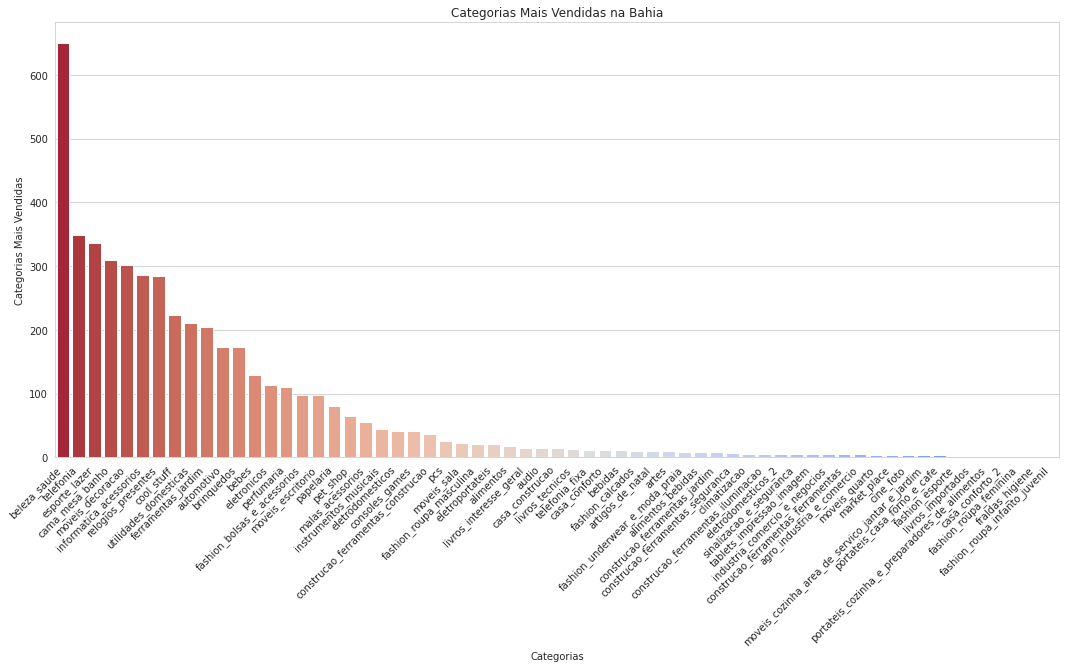

In [148]:
sns.set_style("whitegrid")

plt.figure(figsize=(18,8))

sns.barplot(x=ds_produtos_pedidos_estados['BA'].index,
            y=ds_produtos_pedidos_estados['BA'].values,
            palette=sns.color_palette("coolwarm_r", n_colors=len(ds_produtos_pedidos_estados['BA']) + 4))
locs, labels = plt.xticks()
plt.title("Categorias Mais Vendidas na Bahia")
plt.xlabel('Categorias')
plt.ylabel('Categorias Mais Vendidas')
plt.setp(labels, rotation=45, horizontalalignment='right')
plt.show()

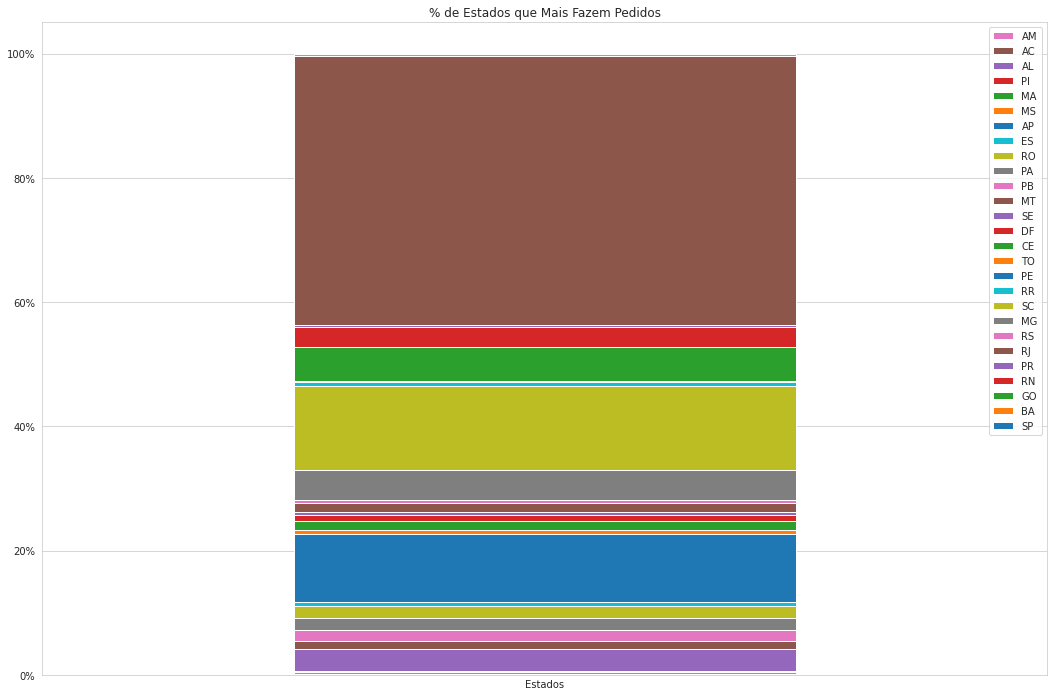

In [149]:
ds_produtos_pedidos.assign(dummy = 1).groupby(['dummy','customer_state']
).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()
).to_frame().unstack().plot(kind='bar', stacked = True, legend = False, figsize = (18, 12), layout = (3,4))


plt.title('% de Estados que Mais Fazem Pedidos')
plt.xlabel('Estados')

plt.xticks([])

current_handles, _ = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
correct_labels = reversed(ds_produtos_pedidos['customer_state'].unique())

plt.legend(reversed_handles,correct_labels)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [150]:
ds_vendedor_pedido.head()

seller_id  ... order_status
0  3442f8959a84dea7ee197c632cb2df15  ...    delivered
1  3442f8959a84dea7ee197c632cb2df15  ...    delivered
2  3442f8959a84dea7ee197c632cb2df15  ...    delivered
3  d1b65fc7debc3361ea86b5f14c68d2e2  ...    delivered
4  d1b65fc7debc3361ea86b5f14c68d2e2  ...    delivered

[5 rows x 7 columns]

In [151]:
ds_vendedor_pedido_temp = ds_vendedor_pedido[['seller_id', 'seller_city', 'seller_state', 'order_id']].drop_duplicates()

In [152]:
ds_pedidos_itens_unicos = ds_pedidos_itens_unicos.merge(ds_vendedor_pedido_temp[['seller_id', 'seller_city', 'seller_state', 'order_id']], on='order_id')

ds_pedidos_itens_unicos.reset_index()

ds_pedidos_itens_unicos.head()

order_id  ... seller_state
0  e481f51cbdc54678b7cc49136f2d6af7  ...           SP
1  e481f51cbdc54678b7cc49136f2d6af7  ...           SP
2  e481f51cbdc54678b7cc49136f2d6af7  ...           SP
3  53cdb2fc8bc7dce0b6741e2150273451  ...           SP
4  47770eb9100c2d0c44946d9cf07ec65d  ...           SP

[5 rows x 22 columns]

In [153]:
ds_pedidos_itens_unicos.query("order_id == '8272b63d03f5f79c56e9e4120aec44ef'")

order_id  ... seller_state
92001  8272b63d03f5f79c56e9e4120aec44ef  ...           SP

[1 rows x 22 columns]

In [154]:
ds_pedidos_itens_unicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103004 entries, 0 to 103003
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103004 non-null  object        
 1   customer_id                    103004 non-null  object        
 2   order_status                   103004 non-null  object        
 3   order_purchase_timestamp       103004 non-null  datetime64[ns]
 4   order_approved_at              103004 non-null  datetime64[ns]
 5   order_delivered_carrier_date   103004 non-null  datetime64[ns]
 6   order_delivered_customer_date  103004 non-null  datetime64[ns]
 7   order_estimated_delivery_date  103004 non-null  datetime64[ns]
 8   vl_tot_pedido                  103004 non-null  float64       
 9   qt_item                        103004 non-null  float64       
 10  freight_value                  103004 non-null  float64       
 11  

In [155]:
ds_pedidos_itens_unicos.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
vl_tot_pedido                    0
qt_item                          0
freight_value                    0
customer_city                    0
customer_state                   0
payment_type                     0
payment_installments             0
payment_type_cat                 0
ano_venda                        0
mes_venda                        0
dia_venda                        0
seller_id                        0
seller_city                      0
seller_state                     0
dtype: int64

## Comportamento das entregas realizadas

In [156]:
pd.set_option('mode.chained_assignment', None)
ds_pedidos_itens_unicos_delivered = ds_pedidos_itens_unicos.query('order_status == "delivered"')

ds_pedidos_itens_unicos_delivered['order_delivered_customer_date_without_hours'] = ds_pedidos_itens_unicos_delivered['order_delivered_customer_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

ds_pedidos_itens_unicos_delivered_antes = ds_pedidos_itens_unicos_delivered.query('order_delivered_customer_date_without_hours < order_estimated_delivery_date')
ds_pedidos_itens_unicos_delivered_depois = ds_pedidos_itens_unicos_delivered.query('order_delivered_customer_date_without_hours > order_estimated_delivery_date')
ds_pedidos_itens_unicos_delivered_dia = ds_pedidos_itens_unicos_delivered.query('order_delivered_customer_date_without_hours == order_estimated_delivery_date')

In [157]:
total_entregas = ds_pedidos_itens_unicos_delivered['order_id'].count()

percentual_entrega_antes = (ds_pedidos_itens_unicos_delivered_antes['order_id'].count() / total_entregas) * 100
percentual_entrega_depois = (ds_pedidos_itens_unicos_delivered_depois['order_id'].count() / total_entregas) * 100
percentual_entrega_dia = (ds_pedidos_itens_unicos_delivered_dia['order_id'].count() / total_entregas) * 100

print('De acordo com a amostra de dados, temos {0} entregas realizadas.'.format(total_entregas))
print('\nDe todas as entregas, {0}% delas foram realizadas antes da estimativa prevista.'.format(round(percentual_entrega_antes, 2)))
print('\nEnquanto que {0}% delas foram realizadas na data prevista.'.format(round(percentual_entrega_dia, 2)))
print('\nPor fim, tivemos apenas {0}% de entregas fora do prazo previsto.'.format(round(percentual_entrega_depois, 2)))


De acordo com a amostra de dados, temos 100762 entregas realizadas.

De todas as entregas, 92.04% delas foram realizadas antes da estimativa prevista.

Enquanto que 1.31% delas foram realizadas na data prevista.

Por fim, tivemos apenas 6.65% de entregas fora do prazo previsto.


In [158]:
ds_pedidos_itens_unicos_delivered['order_delivered_customer_date_with_hours'] = ds_pedidos_itens_unicos_delivered['order_delivered_customer_date'].apply(lambda x: x.strftime('%H:%M:%S'))

ds_pedidos_itens_unicos_delivered = ds_pedidos_itens_unicos_delivered.sort_values(by = ['order_delivered_customer_date_with_hours'], ascending=False)

ds_pedidos_itens_unicos_delivered['order_delivered_customer_date_with_hours'] = pd.to_datetime(ds_pedidos_itens_unicos_delivered['order_delivered_customer_date_with_hours'], format='%H:%M:%S')

ds_pedidos_itens_unicos_delivered_2016 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2016')
ds_pedidos_itens_unicos_delivered_2017 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2017')
ds_pedidos_itens_unicos_delivered_2018 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2018')

## Hora das Entregas no Ano de 2016 por Estado

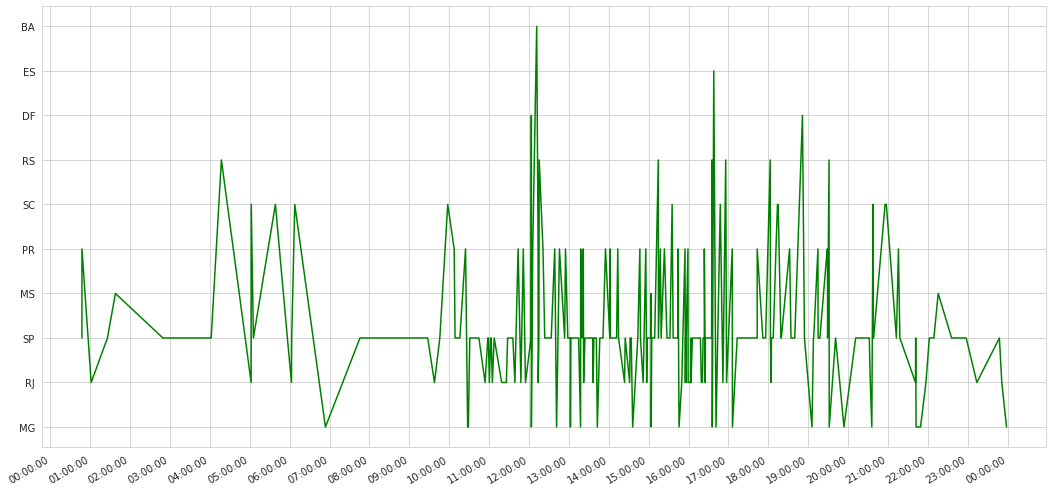

In [159]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_delivered_customer_date_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2016, color = 'g')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2016['order_delivered_customer_date_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2016['order_delivered_customer_date_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show()  

## Hora das Entregas no Ano de 2018 por Estado

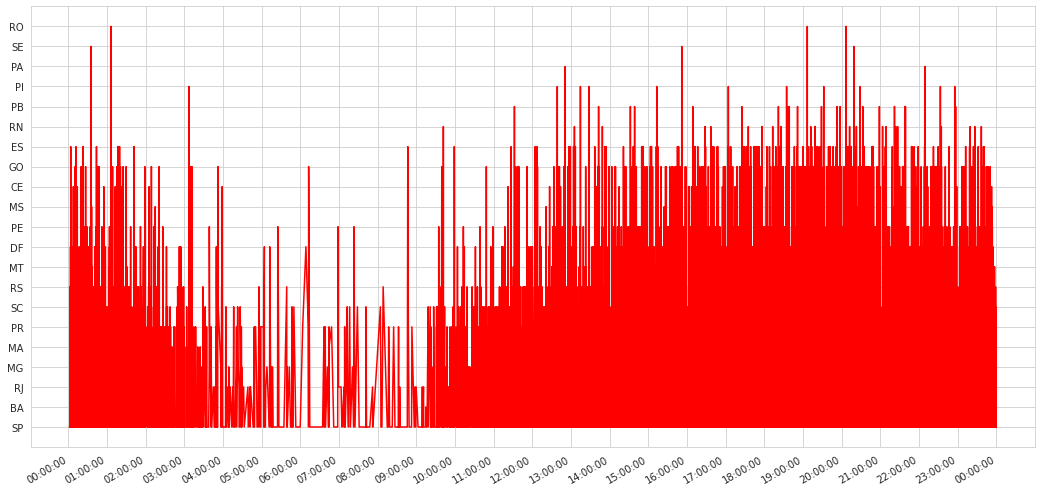

In [160]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_delivered_customer_date_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2018, color = 'r')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2018['order_delivered_customer_date_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2018['order_delivered_customer_date_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show()  

## Hora das Entregas no Ano de 2017 por Estado

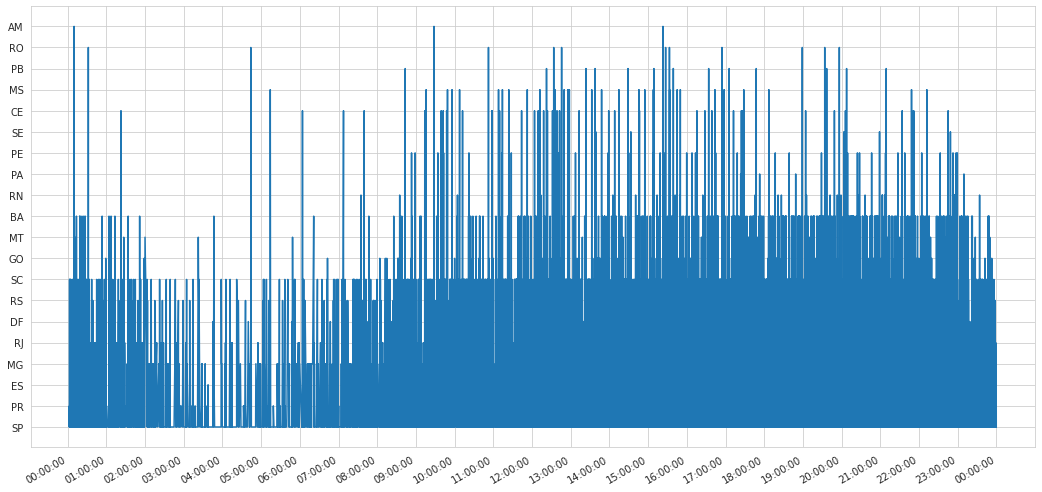

In [161]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_delivered_customer_date_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2017)
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2017['order_delivered_customer_date_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2017['order_delivered_customer_date_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show()  

# Horário de Compras por Estado

In [162]:
ds_pedidos_itens_unicos_delivered['order_purchase_timestamp_with_hours'] = ds_pedidos_itens_unicos_delivered['order_purchase_timestamp'].apply(lambda x: x.strftime('%H:%M:%S'))

ds_pedidos_itens_unicos_delivered = ds_pedidos_itens_unicos_delivered.sort_values(by = ['order_purchase_timestamp_with_hours'], ascending=False)

ds_pedidos_itens_unicos_delivered['order_purchase_timestamp_with_hours'] = pd.to_datetime(ds_pedidos_itens_unicos_delivered['order_purchase_timestamp_with_hours'], format='%H:%M:%S')

ds_pedidos_itens_unicos_delivered_2016 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2016')
ds_pedidos_itens_unicos_delivered_2017 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2017')
ds_pedidos_itens_unicos_delivered_2018 = ds_pedidos_itens_unicos_delivered.query('ano_venda == 2018')

## Compras 2016

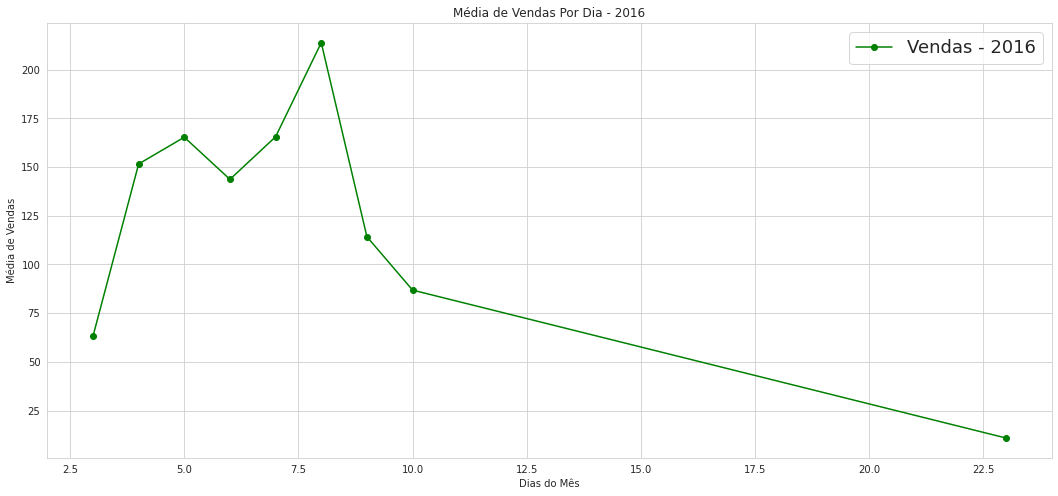

In [163]:
ds_dia_vendas_total = ds_pedidos_itens_unicos_delivered_2016.groupby('dia_venda')['vl_tot_pedido'].mean()
ds_dia_vendas_total.reset_index()

plt.figure(figsize=(18,8))
plt.plot(ds_dia_vendas_total.index, ds_dia_vendas_total.values, label = "Vendas - 2016", marker='o', color='g')
plt.legend(fontsize=18)
plt.title('Média de Vendas Por Dia - 2016')
plt.xlabel('Dias do Mês')
plt.ylabel('Média de Vendas')
plt.show()

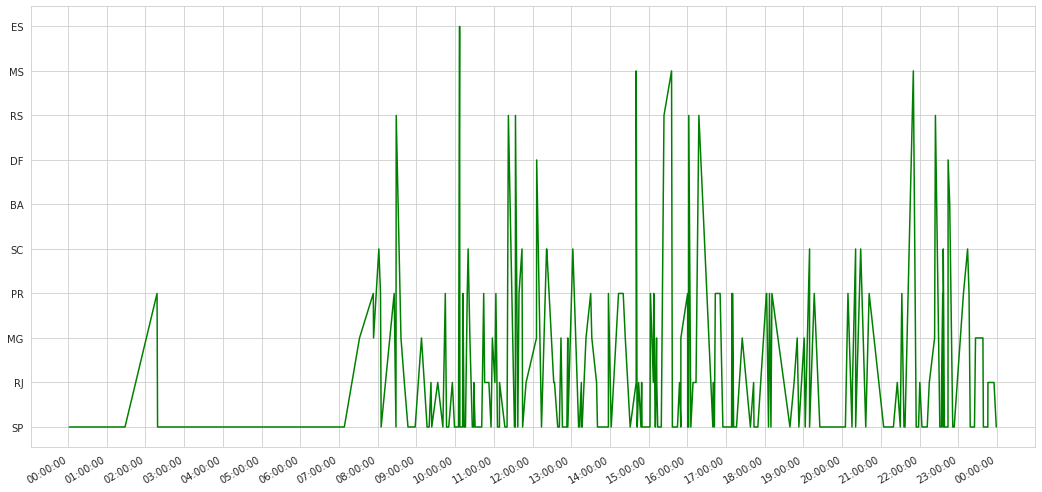

In [164]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_purchase_timestamp_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2016, color = 'g')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2016['order_purchase_timestamp_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2016['order_purchase_timestamp_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show()  

## Compras 2017

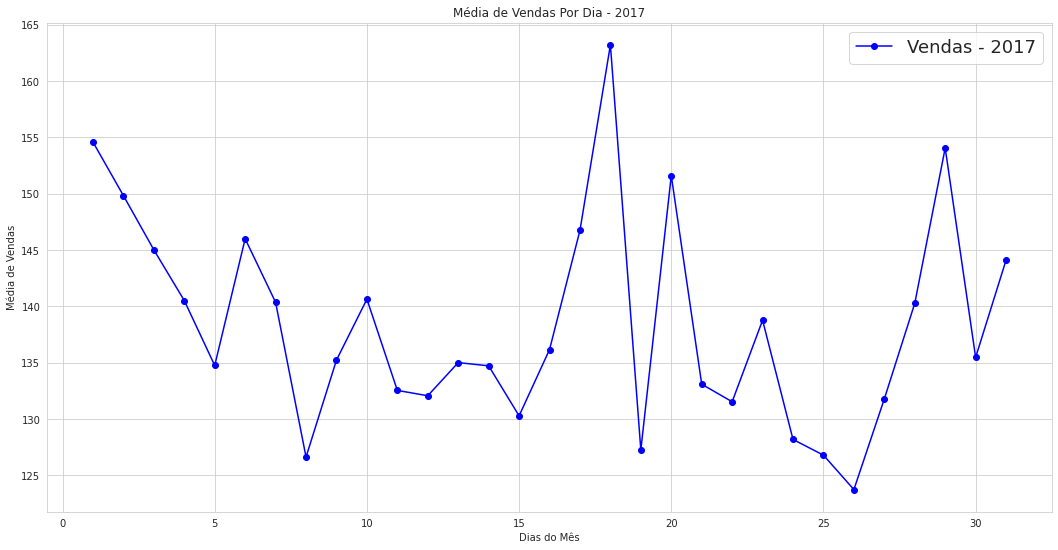

In [165]:
ds_dia_vendas_total = ds_pedidos_itens_unicos_delivered_2017.groupby('dia_venda')['vl_tot_pedido'].mean()
ds_dia_vendas_total.reset_index()

plt.figure(figsize=(18,9))
plt.plot(ds_dia_vendas_total.index, ds_dia_vendas_total.values, label = "Vendas - 2017", marker='o', color='b')
plt.legend(fontsize=18)
plt.title('Média de Vendas Por Dia - 2017')
plt.xlabel('Dias do Mês')
plt.ylabel('Média de Vendas')
plt.show()

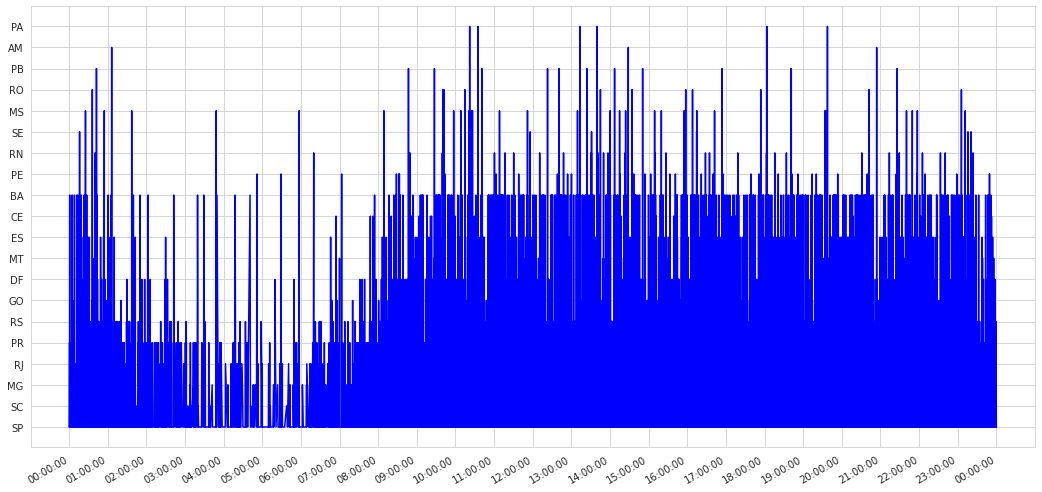

In [166]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_purchase_timestamp_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2017, color = 'b')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2017['order_purchase_timestamp_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2017['order_purchase_timestamp_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show() 

## Compras 2018

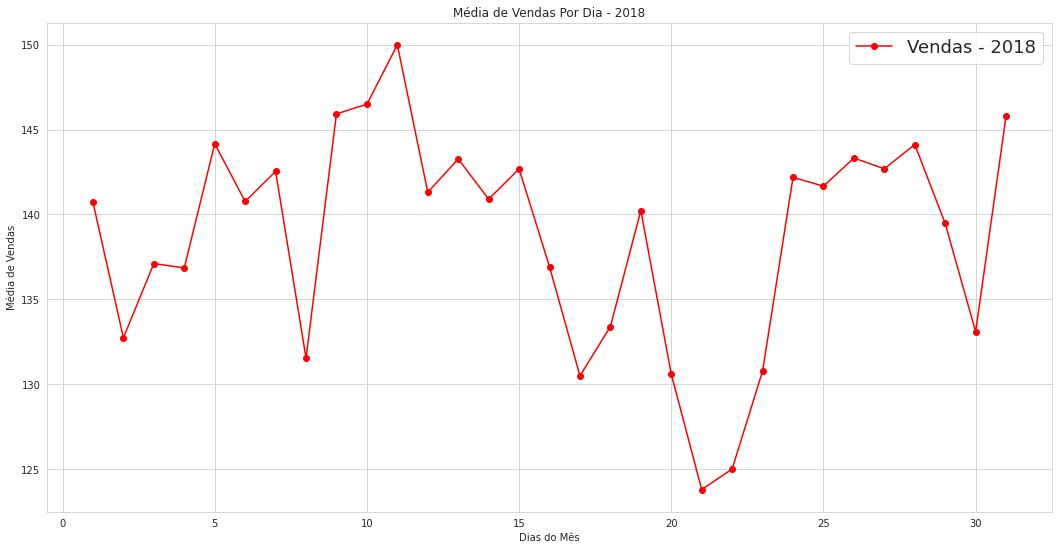

In [167]:
ds_dia_vendas_total = ds_pedidos_itens_unicos_delivered_2018.groupby('dia_venda')['vl_tot_pedido'].mean()
ds_dia_vendas_total.reset_index()

plt.figure(figsize=(18,9))
plt.plot(ds_dia_vendas_total.index, ds_dia_vendas_total.values, label = "Vendas - 2018", marker='o', color='r')
plt.legend(fontsize=18)
plt.title('Média de Vendas Por Dia - 2018')
plt.xlabel('Dias do Mês')
plt.ylabel('Média de Vendas')
plt.show()

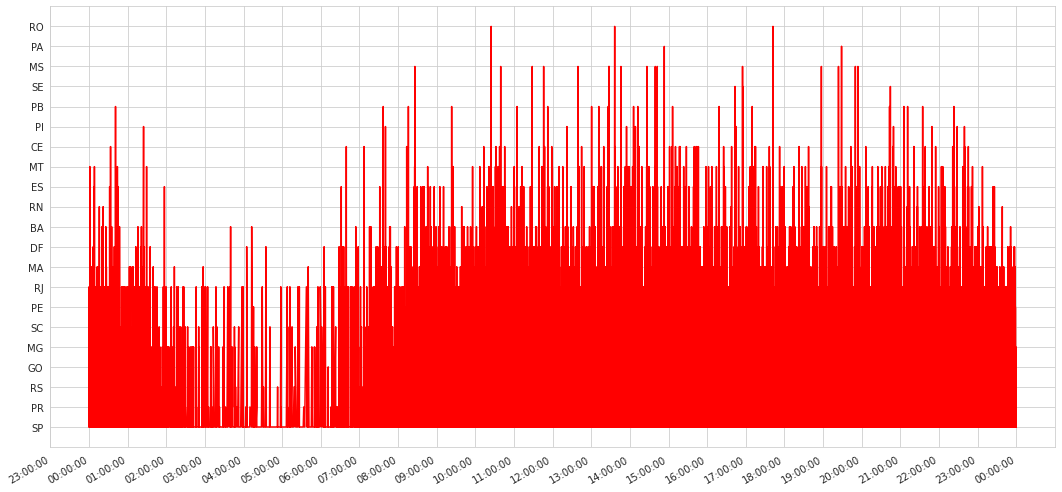

In [168]:
fig, ax = plt.subplots(figsize=(18,9))

plt.plot('order_purchase_timestamp_with_hours', 'seller_state', data=ds_pedidos_itens_unicos_delivered_2018, color = 'r')
ax.set_xlim(ds_pedidos_itens_unicos_delivered_2018['order_purchase_timestamp_with_hours'].min()-pd.Timedelta(1,'h'),
            ds_pedidos_itens_unicos_delivered_2018['order_purchase_timestamp_with_hours'].max()+pd.Timedelta(1,'h'))

ax.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))

fig.autofmt_xdate()

plt.show() 

## Vendas e Fretes por Ano

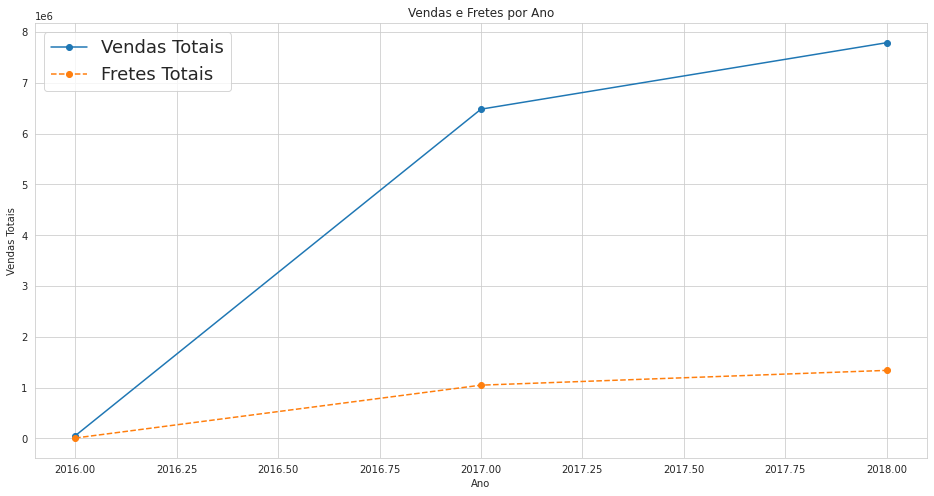

In [169]:
ds_ano_vendas_total = ds_pedidos_itens_unicos.groupby('ano_venda')['vl_tot_pedido'].sum()
ds_ano_vendas_total.reset_index()

ds_ano_frete_total = ds_pedidos_itens_unicos.groupby('ano_venda')['freight_value'].sum()
ds_ano_frete_total.reset_index()

plt.figure(figsize=(16,8))
plt.plot(ds_ano_vendas_total.index, ds_ano_vendas_total.values, label = "Vendas Totais", marker='o')
plt.plot(ds_ano_frete_total.index, ds_ano_frete_total.values, label = "Fretes Totais", linestyle="--", marker='o')
plt.legend(fontsize=18)
plt.title('Vendas e Fretes por Ano')
plt.xlabel('Ano')
plt.ylabel('Vendas Totais')
plt.show()

## Vendas e Fretes por Mês - Acumulado

#### Pelo gráfico podemos concluir que as maiores vendas ocorrem no meio do ano, entre Março e Setembro.
#### O crescimento nas vendas começa ocorrer após o evento do carnaval.

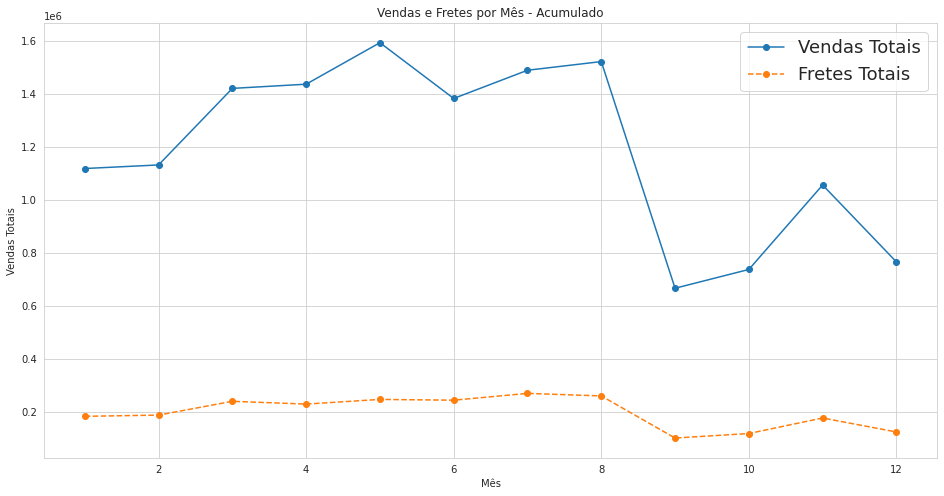

In [170]:
ds_mes_vendas_total = ds_pedidos_itens_unicos.groupby('mes_venda')['vl_tot_pedido'].sum()
ds_mes_vendas_total.reset_index()

ds_mes_frete_total = ds_pedidos_itens_unicos.groupby('mes_venda')['freight_value'].sum()
ds_mes_frete_total.reset_index()

plt.figure(figsize=(16,8))
plt.plot(ds_mes_vendas_total.index, ds_mes_vendas_total.values, label = "Vendas Totais", marker='o')
plt.plot(ds_mes_frete_total.index, ds_mes_frete_total.values, label = "Fretes Totais", linestyle="--", marker='o')
plt.legend(fontsize=18)
plt.title('Vendas e Fretes por Mês - Acumulado')
plt.xlabel('Mês')
plt.ylabel('Vendas Totais')
plt.show()

## Vendas, Fretes e Clientes por Mês/Ano

#### Os gráficos abaixo são semelhantes, isto mostra que o crescimento nas vendas é também um crescimento de novos clientes, já que clientes vs pedidos são de 1:1. 

#### Portanto, podemos concluir que o LTV, de acordo com esta amostra, é alto, ocasionando maior investimento na aquisição de clientes. 

#### A Recorrência de clientes em voltar a comprar produtos é muito baixa.

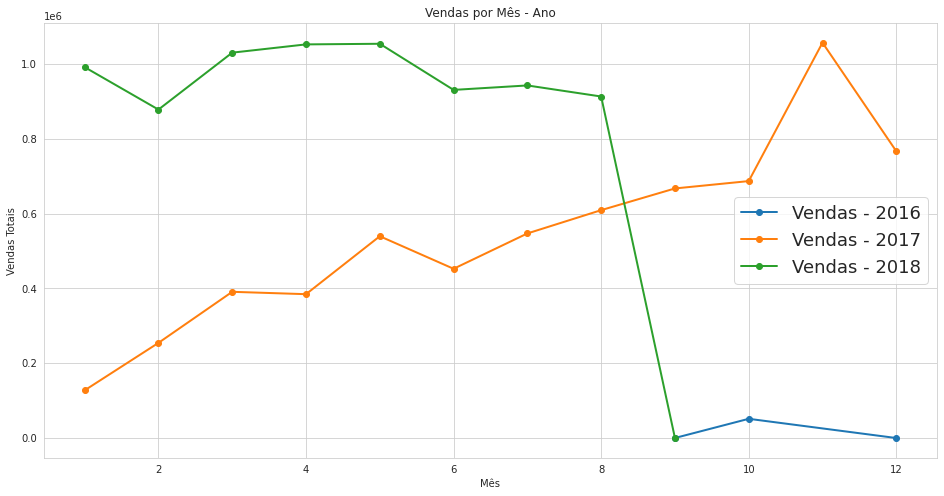

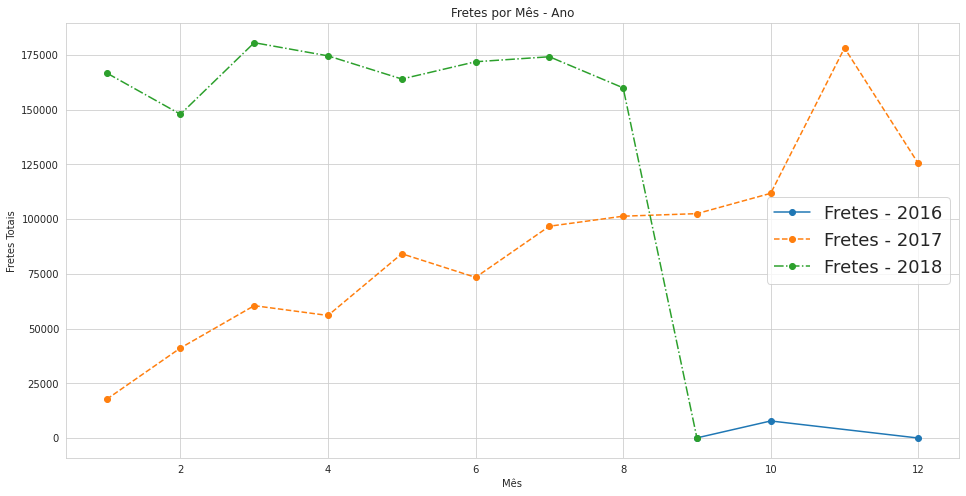

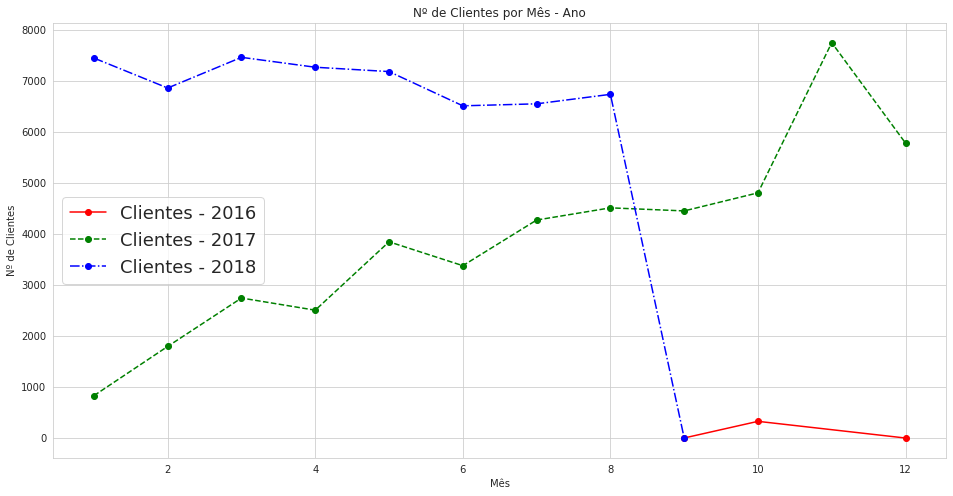

In [171]:
# Vendas, frete e cliente mês a mês de cada ano
ds_mes_ano_vendas_total_01 = ds_pedidos_itens_unicos.query('ano_venda == 2016').groupby('mes_venda')['vl_tot_pedido'].sum()
ds_mes_ano_vendas_total_02 = ds_pedidos_itens_unicos.query('ano_venda == 2017').groupby('mes_venda')['vl_tot_pedido'].sum()
ds_mes_ano_vendas_total_03 = ds_pedidos_itens_unicos.query('ano_venda == 2018').groupby('mes_venda')['vl_tot_pedido'].sum()

plt.figure(figsize=(16,8))

# Vendas
plt.plot(ds_mes_ano_vendas_total_01.index, ds_mes_ano_vendas_total_01.values, label = "Vendas - 2016", linewidth=2, marker='o')

plt.plot(ds_mes_ano_vendas_total_02.index, ds_mes_ano_vendas_total_02.values, label = "Vendas - 2017", linewidth=2, marker='o')

plt.plot(ds_mes_ano_vendas_total_03.index, ds_mes_ano_vendas_total_03.values, label = "Vendas - 2018", linewidth=2, marker='o')

plt.legend(fontsize=18)
plt.title('Vendas por Mês - Ano')
plt.xlabel('Mês')
plt.ylabel('Vendas Totais')
plt.show()

ds_mes_ano_frete_total_01 = ds_pedidos_itens_unicos.query('ano_venda == 2016').groupby('mes_venda')['freight_value'].sum()
ds_mes_ano_frete_total_02 = ds_pedidos_itens_unicos.query('ano_venda == 2017').groupby('mes_venda')['freight_value'].sum()
ds_mes_ano_frete_total_03 = ds_pedidos_itens_unicos.query('ano_venda == 2018').groupby('mes_venda')['freight_value'].sum()

plt.figure(figsize=(16,8))

# Frete
plt.plot(ds_mes_ano_frete_total_01.index, ds_mes_ano_frete_total_01.values, label = "Fretes - 2016", linestyle="-", marker='o')

plt.plot(ds_mes_ano_frete_total_02.index, ds_mes_ano_frete_total_02.values, label = "Fretes - 2017", linestyle="--", marker='o')

plt.plot(ds_mes_ano_frete_total_03.index, ds_mes_ano_frete_total_03.values, label = "Fretes - 2018", linestyle="-.", marker='o')

plt.legend(fontsize=18)
plt.title('Fretes por Mês - Ano')
plt.xlabel('Mês')
plt.ylabel('Fretes Totais')
plt.show()

ds_mes_ano_cliente_total_01 = ds_pedidos_itens_unicos.query('ano_venda == 2016').groupby('mes_venda')['customer_id'].count()
ds_mes_ano_cliente_total_02 = ds_pedidos_itens_unicos.query('ano_venda == 2017').groupby('mes_venda')['customer_id'].count()
ds_mes_ano_cliente_total_03 = ds_pedidos_itens_unicos.query('ano_venda == 2018').groupby('mes_venda')['customer_id'].count()

plt.figure(figsize=(16,8))

# Clientes
plt.plot(ds_mes_ano_cliente_total_01.index, ds_mes_ano_cliente_total_01.values, label = "Clientes - 2016", linestyle="-", marker='o', color='r')

plt.plot(ds_mes_ano_cliente_total_02.index, ds_mes_ano_cliente_total_02.values, label = "Clientes - 2017", linestyle="--", marker='o', color='g')

plt.plot(ds_mes_ano_cliente_total_03.index, ds_mes_ano_cliente_total_03.values, label = "Clientes - 2018", linestyle="-.", marker='o', color='b')

plt.legend(fontsize=18)
plt.title('Nº de Clientes por Mês - Ano')
plt.xlabel('Mês')
plt.ylabel('Nº de Clientes')
plt.show()

## As vendas estão concentradas em cartão de crédito e boleto, ultrapassando 90% das vendas.

In [172]:
ds_pedidos_itens_unicos.head()

order_id  ... seller_state
0  e481f51cbdc54678b7cc49136f2d6af7  ...           SP
1  e481f51cbdc54678b7cc49136f2d6af7  ...           SP
2  e481f51cbdc54678b7cc49136f2d6af7  ...           SP
3  53cdb2fc8bc7dce0b6741e2150273451  ...           SP
4  47770eb9100c2d0c44946d9cf07ec65d  ...           SP

[5 rows x 22 columns]

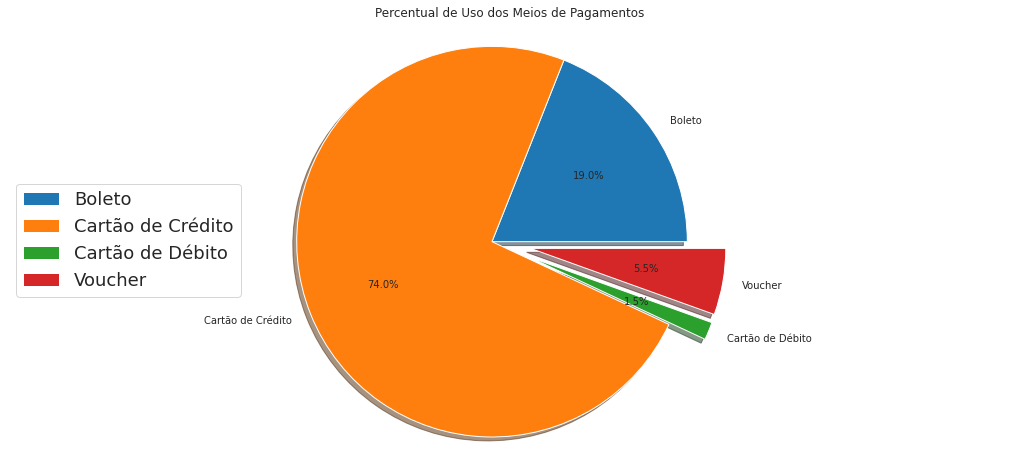

In [208]:
ds_tipo_pg_pedido = ds_pedidos_itens_unicos.groupby(['payment_type'])['order_id'].count()

# Remove not_defined
ds_tipo_pg_pedido = ds_tipo_pg_pedido.drop(ds_tipo_pg_pedido.index[3])

labels = ['Boleto', 'Cartão de Crédito', 'Cartão de Débito', 'Voucher']

explode = (0.0, 0.0, 0.2, 0.2) 

plt.figure(figsize=(18,8))

plt.pie(ds_tipo_pg_pedido, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode)

plt.legend(labels, loc=6, fontsize=18)
plt.title('Percentual de Uso dos Meios de Pagamentos')
plt.axis('equal')

plt.show()

## Uso dos tipos de pagamento mês a mês

### De Março a Setembro é o período de maior vendas, e também, o de maior uso de cartão de crédito.

In [174]:
ds_tipo_boleto_mes       = ds_pedidos_itens_unicos.query('payment_type == "boleto"').groupby('mes_venda')['payment_type'].count()
ds_tipo_credit_card_mes  = ds_pedidos_itens_unicos.query('payment_type == "credit_card"').groupby('mes_venda')['payment_type'].count()
ds_tipo_debit_card_mes   = ds_pedidos_itens_unicos.query('payment_type == "debit_card"').groupby('mes_venda')['payment_type'].count()
ds_tipo_voucher_mes      = ds_pedidos_itens_unicos.query('payment_type == "voucher"').groupby('mes_venda')['payment_type'].count()

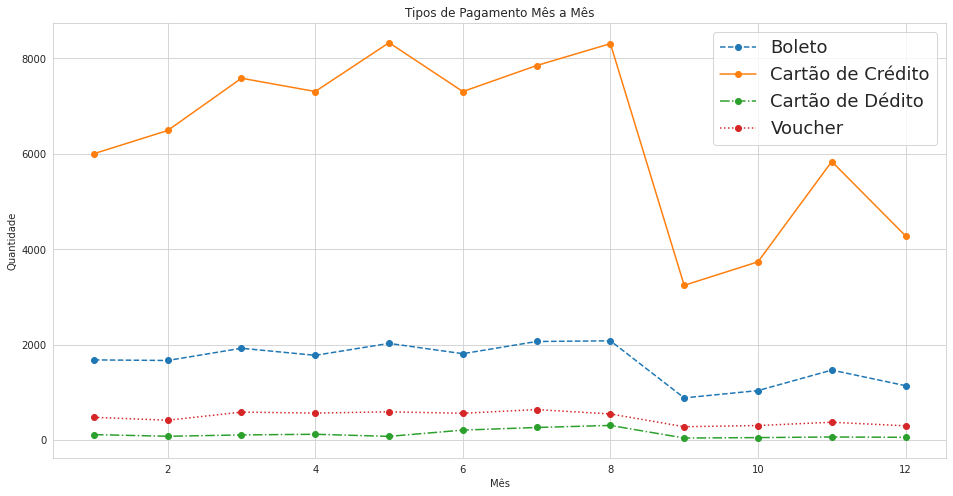

In [175]:
plt.figure(figsize=(16,8))

plt.plot(ds_tipo_boleto_mes.index, ds_tipo_boleto_mes.values, label = "Boleto", linestyle="--", marker='o')

plt.plot(ds_tipo_credit_card_mes.index, ds_tipo_credit_card_mes.values, label = "Cartão de Crédito", linestyle="-", marker='o')

plt.plot(ds_tipo_debit_card_mes.index, ds_tipo_debit_card_mes.values, label = "Cartão de Dédito", linestyle="-.", marker='o')
plt.plot(ds_tipo_voucher_mes.index, ds_tipo_voucher_mes.values, label = "Voucher", linestyle=":", marker='o')

plt.legend(fontsize=18)
plt.title('Tipos de Pagamento Mês a Mês')
plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.show()

## Dias da Semana x Vendas x Tipos de Pagamentos

In [176]:
ds_pedidos_itens_unicos['dia_semana_venda'] = ds_pedidos_itens_unicos['order_purchase_timestamp'].apply(lambda x: x.strftime('%A'))

In [177]:
ds_dia_semana_vendas_totais = ds_pedidos_itens_unicos.groupby('dia_semana_venda')['vl_tot_pedido'].sum()

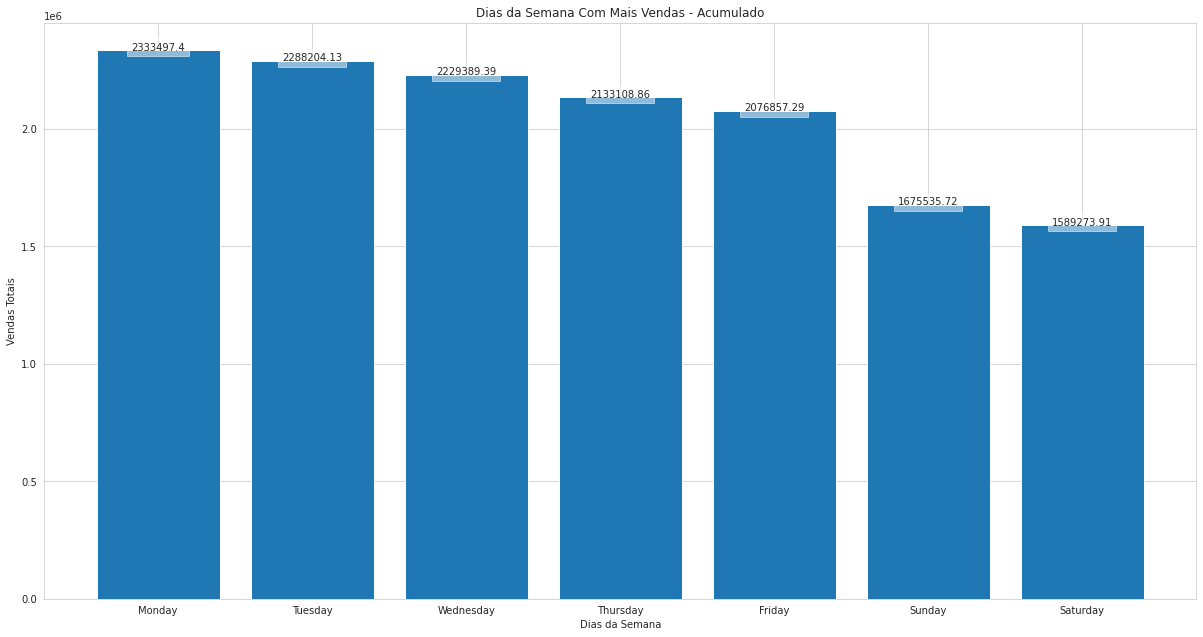

In [178]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',
            bbox = dict(facecolor = 'white', alpha = .5))

ds_dia_semana_vendas_totais = ds_dia_semana_vendas_totais.sort_values(ascending=False)

fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0,0,1,1])

ax.bar(ds_dia_semana_vendas_totais.index, ds_dia_semana_vendas_totais.values)

addlabels(ds_dia_semana_vendas_totais.index, ds_dia_semana_vendas_totais.values)

plt.title('Dias da Semana Com Mais Vendas - Acumulado')
plt.xlabel('Dias da Semana')
plt.ylabel('Vendas Totais')
plt.show()

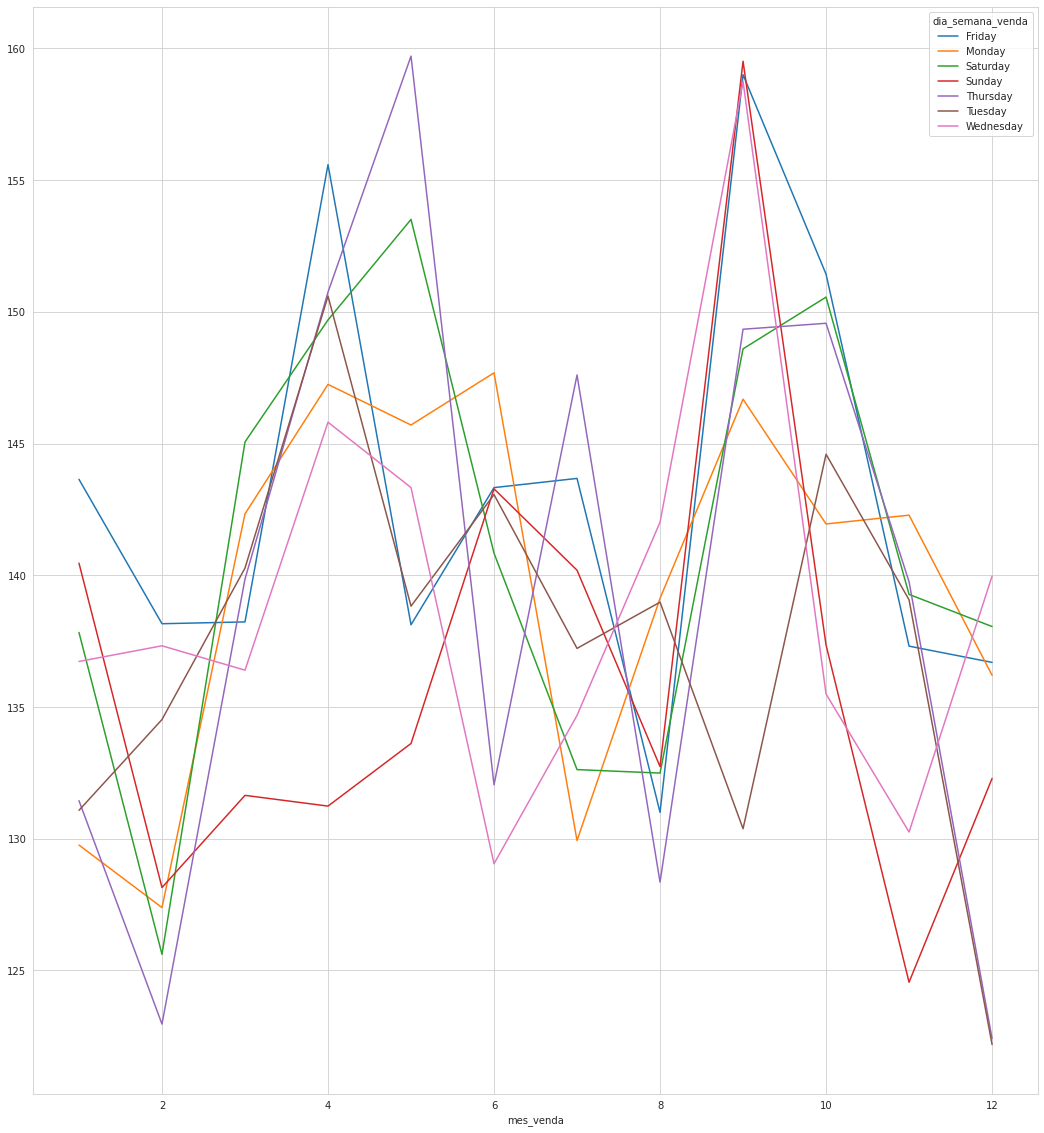

In [179]:
fig, ax = plt.subplots(figsize = (18,20))
ds_pedidos_itens_unicos.groupby(['mes_venda', 'dia_semana_venda']).mean()['vl_tot_pedido'].unstack().plot(ax = ax);

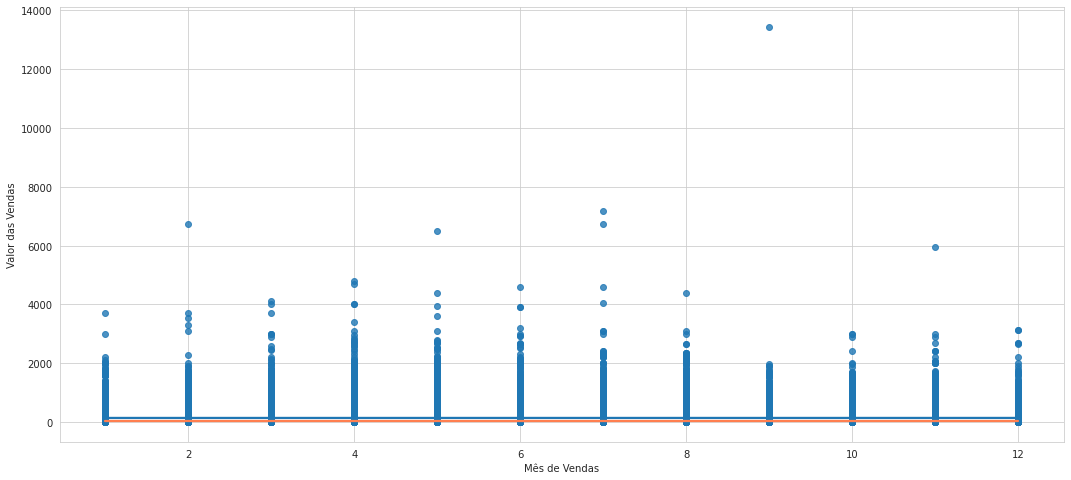

In [180]:
f, ax = plt.subplots(figsize=(18, 8))
sns.regplot(x="mes_venda", y="freight_value", data=ds_pedidos_itens_unicos, ax=ax, color="coral").set(
    xlabel='Mês de Vendas',
    ylabel='Valor das Vendas',  
)
sns.regplot(x="mes_venda", y="vl_tot_pedido", data=ds_pedidos_itens_unicos, ax=ax).set(
    xlabel='Mês de Vendas',
    ylabel='Valor das Vendas',    
)
plt.show()

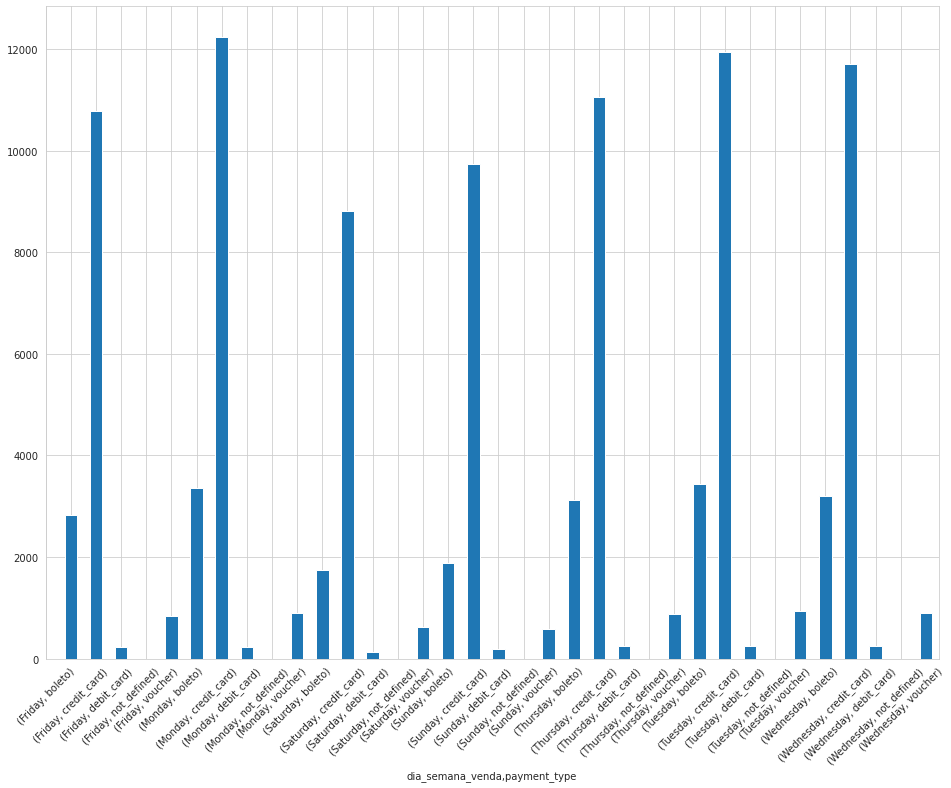

In [181]:
ds_pedidos_itens_unicos.groupby(['dia_semana_venda', 'payment_type'])['payment_type'].count().plot(kind='bar', rot = 45, position = -1.5, figsize = (16, 12), layout=(3,4), align='center');

# Análise para Previsão de Vendas

In [190]:
# id_vendedor = recebe id do vendedor para filtrar a previsão, caso contrário, envie o valor zero 0
# base = recebe o conteúdo a ser previsto, contendo data e valores de vendas predecessoras.
# feriados = recebe um dataframe com datas de feriados (ds, holiday) para a previsão, caso contrário, envie o valor zero 0
# periodo = recebe uma quantidade de dias futuro para previsão das vendas

def previsao_vendas(id_vendedor, base, feriados, periodo):
    if id_vendedor != 0:
        if base[base['seller_id']] == id_vendedor:
            base = base[base['seller_id'] == id_vendedor]
            
    base = base[['order_purchase_timestamp', 'vl_tot_pedido']].rename(columns = {'order_purchase_timestamp': 'ds', 'vl_tot_pedido': 'y'})
    base = base.sort_values(by = 'ds', ascending=True)
    
    if feriados == 0:
        model = Prophet()
    else:
        model = Prophet(holidays = feriados)
    
    model.fit(base)
    
    futuro = model.make_future_dataframe(periods = periodo)
    previsao = model.predict(futuro)
    
    figure_01 = model.plot(previsao, xlabel = 'Data', ylabel = 'Vendas')
    figure_02 = model.plot_components(previsao)
    
    return base, previsao;
        

In [197]:
# Remove itens que sejam outliers gerando um novo dataframe
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


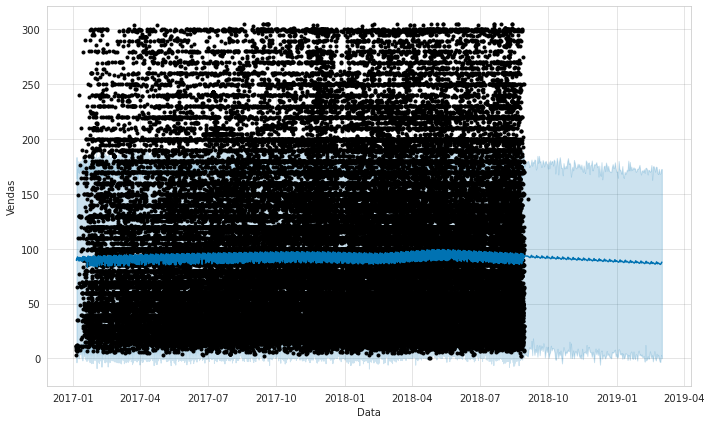

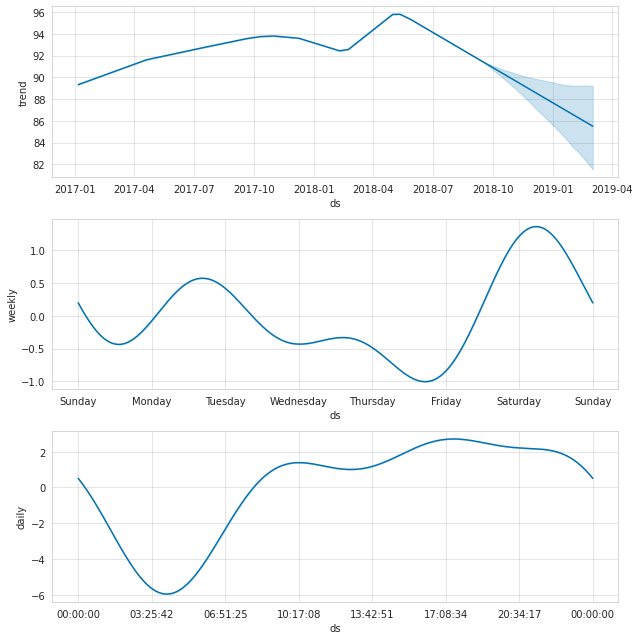

In [198]:
# Previsão de 180 dias a frente
# Dados de predecessores completos são de 2017 e 2018
ds_pedidos_itens_unicos_data_hora = ds_pedidos_itens_unicos.query('ano_venda == 2017 or ano_venda == 2018')

ds_pedidos_itens_unicos_data_hora = ds_pedidos_itens_unicos_data_hora[['order_purchase_timestamp', 'vl_tot_pedido']]

ds_pedidos_itens_unicos_data_hora = remove_outlier(ds_pedidos_itens_unicos_data_hora, 'vl_tot_pedido')

base_original, base_previsao = previsao_vendas(0, 
                                               ds_pedidos_itens_unicos_data_hora, 
                                               0, 
                                               180)

## Previsão de Vendas para os Próximos 180 dias

In [184]:
base_original.shape, base_previsao.shape

((102673, 2), (96552, 19))

In [201]:
base_previsao.tail(5)

ds      trend  ...  multiplicative_terms_upper       yhat
88853 2019-02-26 09:06:57  85.652710  ...                         0.0  86.633279
88854 2019-02-27 09:06:57  85.617370  ...                         0.0  86.253951
88855 2019-02-28 09:06:57  85.582031  ...                         0.0  85.751689
88856 2019-03-01 09:06:57  85.546691  ...                         0.0  86.412158
88857 2019-03-02 09:06:57  85.511352  ...                         0.0  87.811468

[5 rows x 19 columns]

## De acordo com análise dos últimos 2 anos (2017 - 2018), até o início do mês de Setembro, os próximos 180 dias teremos quedas nas vendas.

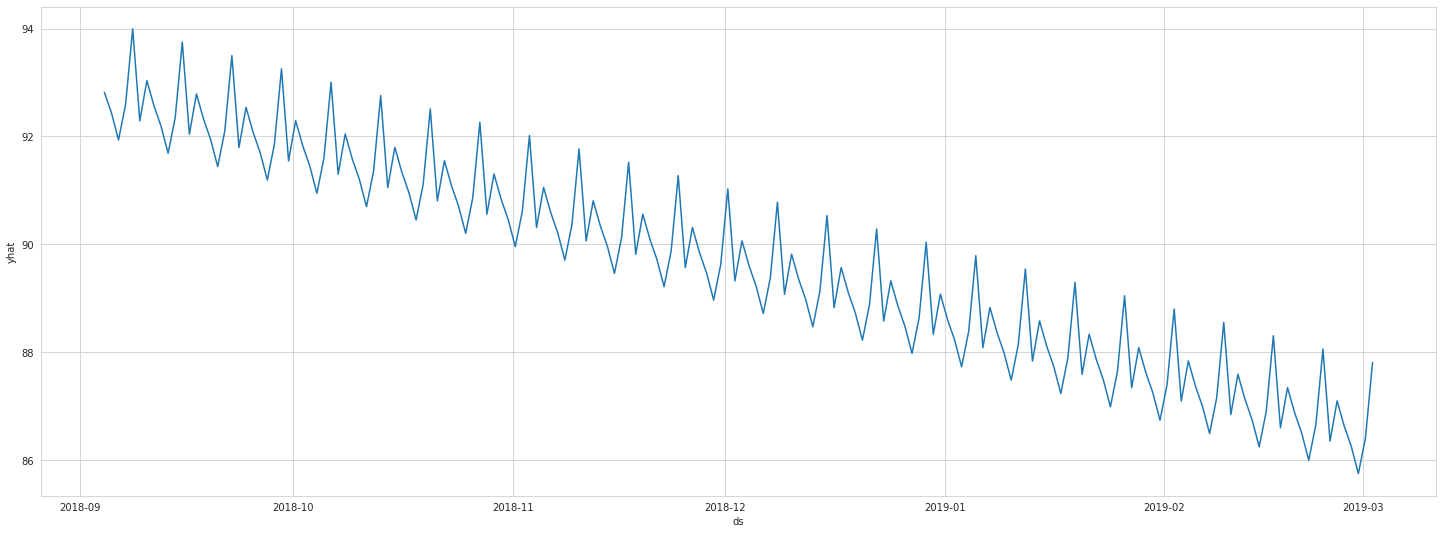

In [200]:
base_previsao_futuro = base_previsao.tail(180)
plt.figure(figsize=(25,9))
sns.lineplot(data=base_previsao_futuro, x="ds", y="yhat");